In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scaler 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import LinearSVC

# pipeline
from sklearn.pipeline import Pipeline 

# resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold, KFold, cross_val_score

# scoring
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# pca
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [2]:
socar_df = pd.read_csv("0. raw_data/insurance_fraud_detect_data.csv")
pd.set_option('display.max_columns', len(socar_df.columns))
socar = socar_df.copy()
socar.tail()

# EDA

## SWEETVIZ

In [ ]:
# import sweetviz as sv

In [ ]:
# socar_report = sv.compare([socar_tr, "Train"], [socar_test, "Test"], "fraud_YN")
# socar_report.show_html('./socar_report.html')

## 데이터셋 기본 정보

In [15]:
socar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fraud_YN               16000 non-null  int64  
 1   car_model              16000 non-null  int64  
 2   sharing_type           16000 non-null  int64  
 3   age_group              16000 non-null  int64  
 4   has_previous_accident  16000 non-null  int64  
 5   cumulative_use_count   16000 non-null  int64  
 6   b2b                    16000 non-null  int64  
 7   accident_ratio         16000 non-null  int64  
 8   pf_type                16000 non-null  int64  
 9   socarpass              16000 non-null  int64  
 10  socarsave              16000 non-null  int64  
 11  start_hour             16000 non-null  int64  
 12  duration               16000 non-null  int64  
 13  accident_hour          16000 non-null  int64  
 14  repair_cost            16000 non-null  float64
 15  in

## 불균형한 데이터(Imbalance dataset)

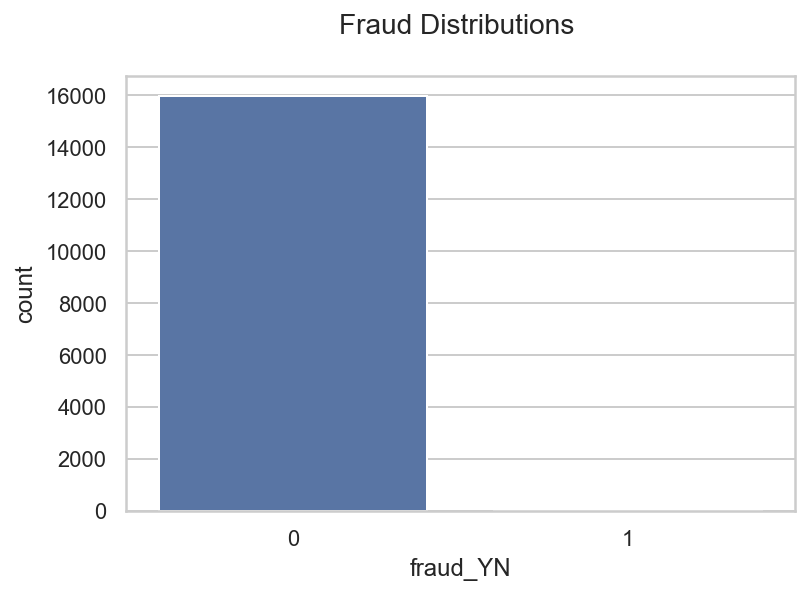

In [16]:
sns.countplot('fraud_YN', data=socar_df)
plt.title("Fraud Distributions \n", fontsize=14)
plt.show()

- 전체 160,000건의 데이터 중 사기 데이터가 41건 밖에 안 됨

## 컬럼별 상관관계 확인 

<Figure size 432x288 with 0 Axes>

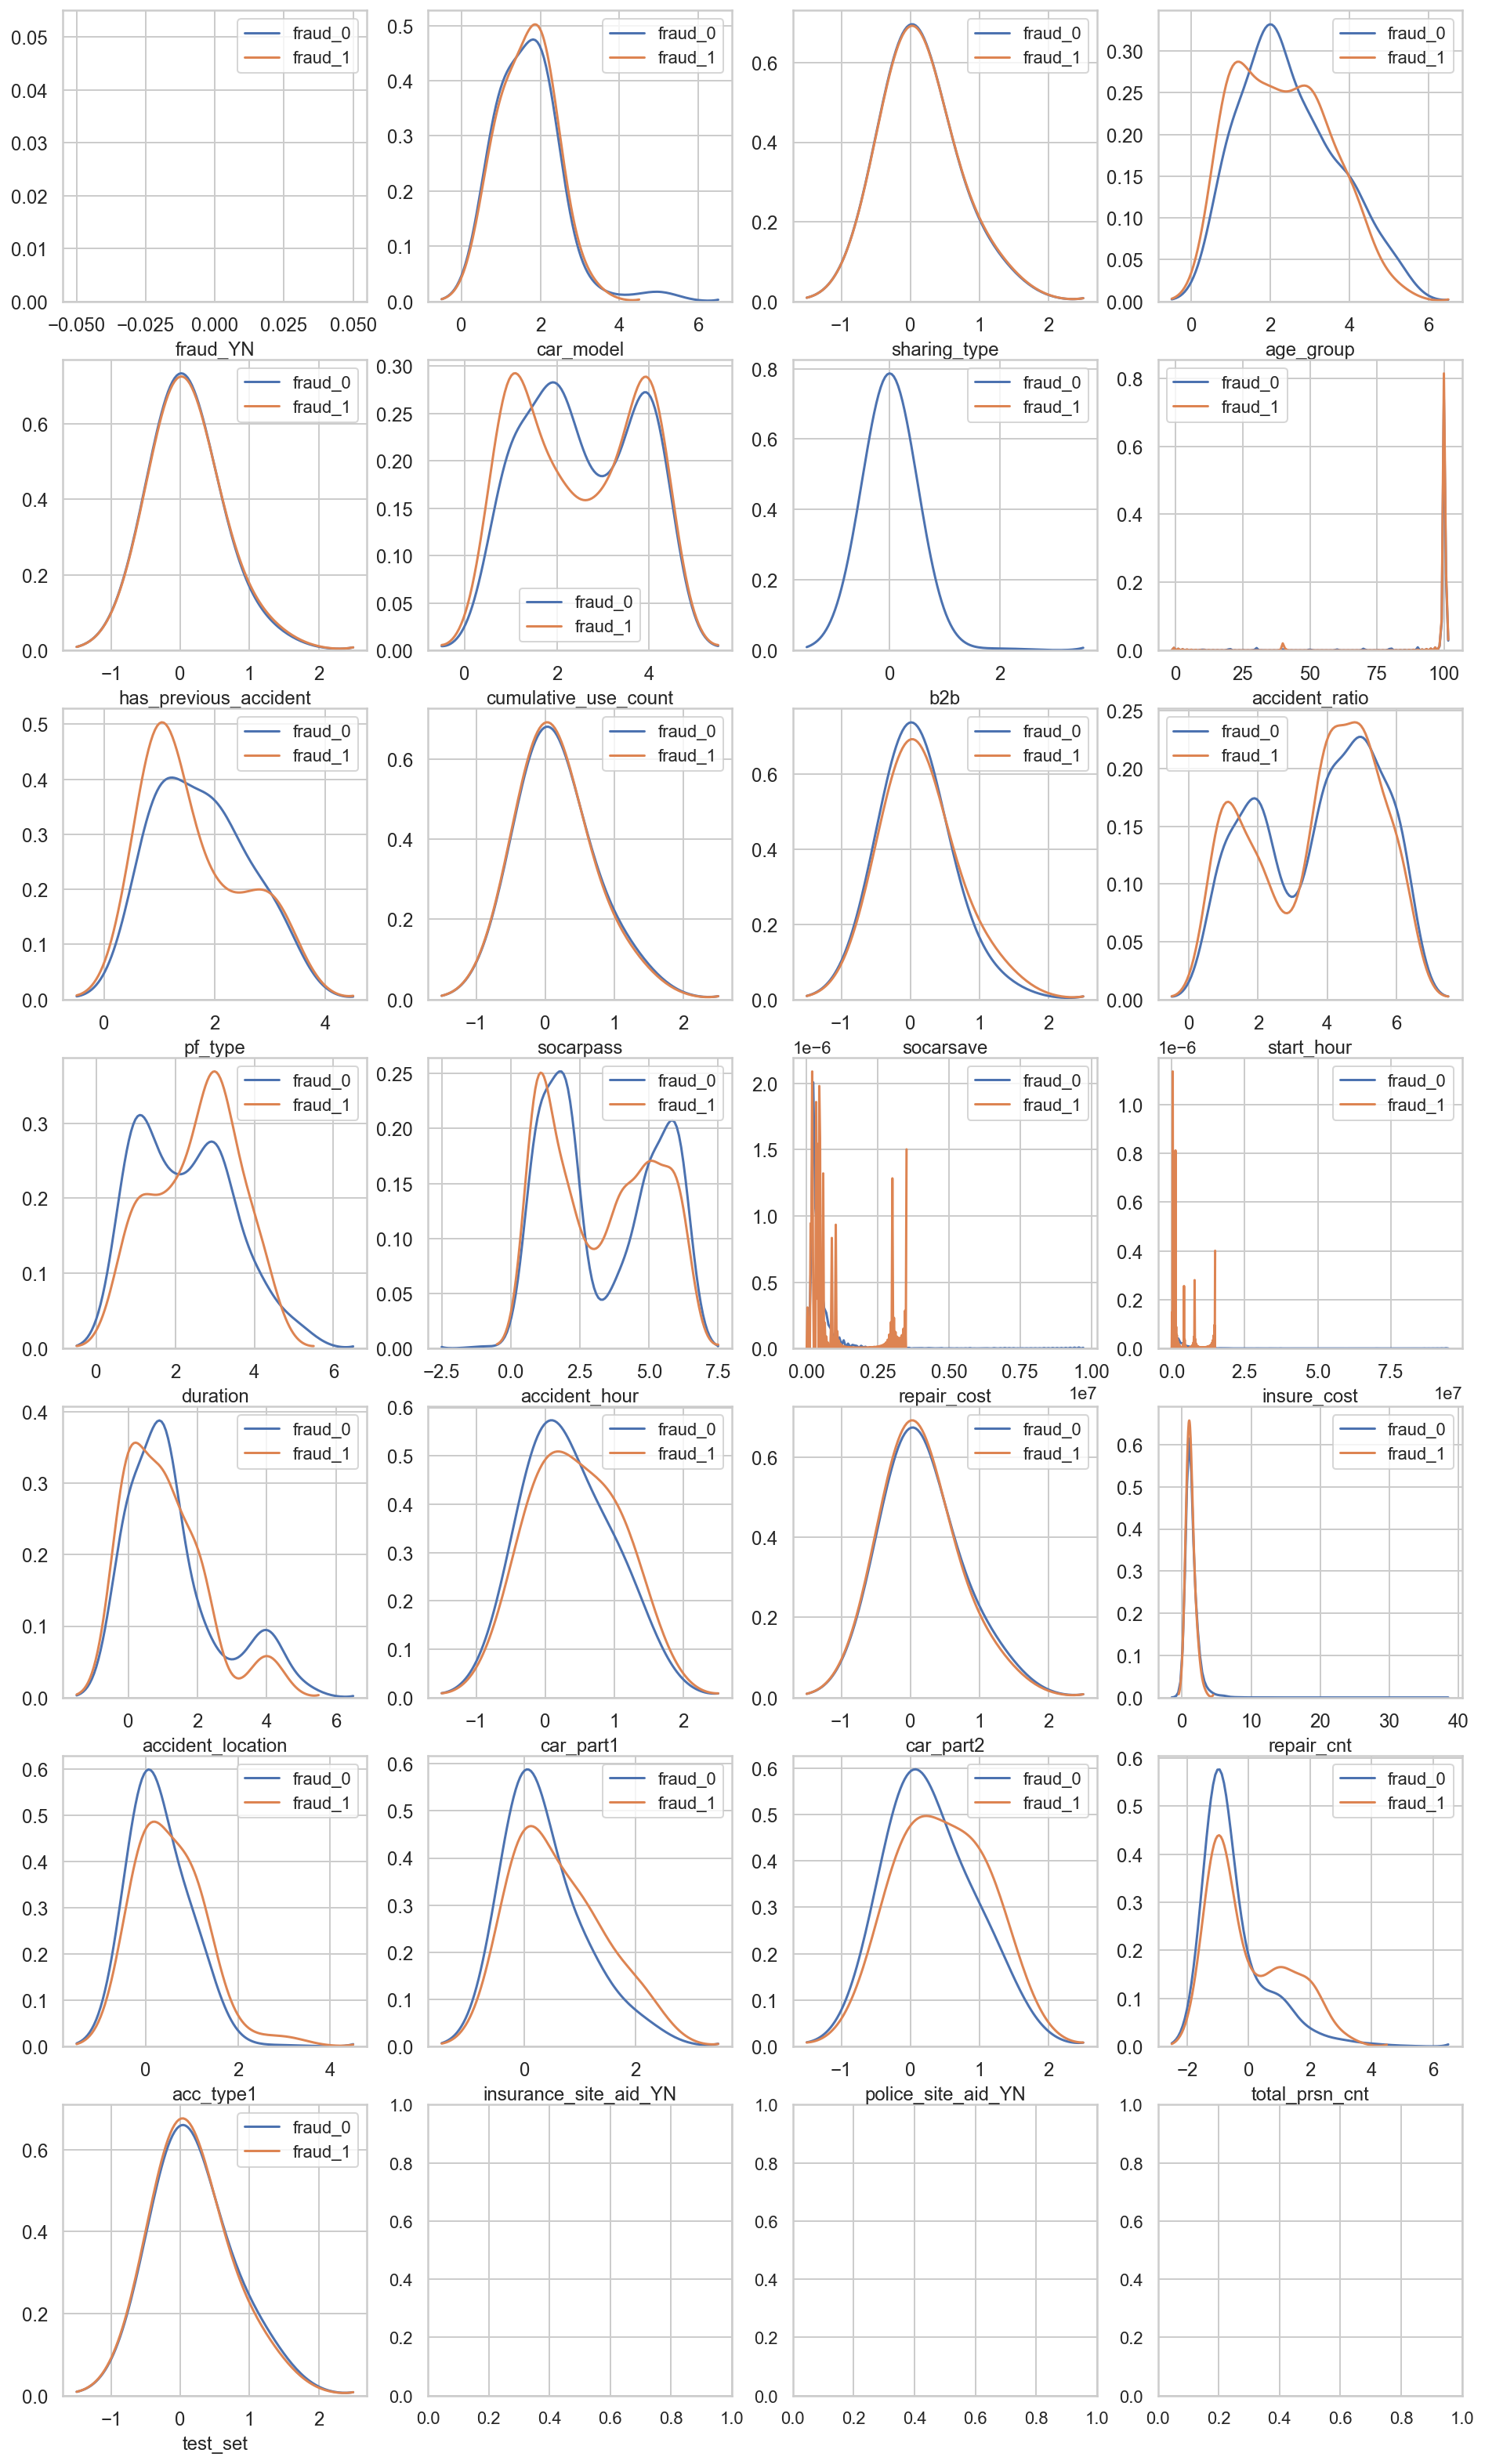

In [17]:
import seaborn as sns

var = socar.columns.values

t0 = socar.loc[socar['fraud_YN']==0]
t1 = socar.loc[socar['fraud_YN']==1]

sns.set_style('whitegrid')
plt.figure()
fig,ax = plt.subplots(7,4,figsize=(16,28))


for i, feature in enumerate(var):
    plt.subplot(7,4,i+1)
    sns.kdeplot(t0[feature], bw=0.5, label = 'fraud_0')
    sns.kdeplot(t1[feature], bw=0.5, label = 'fraud_1')

    plt.xlabel(feature,fontsize=12)
    locs, labels = plt.xticks()

    plt.tick_params(axis='both', which = 'major', labelsize=12)

plt.show()

- fraud와 non-fraud가 비슷한 양상을 보이는 feature는 사기 유무를 판단하는데 영향력이 적을 것으로 예상됨 -> 해당 컬럼 삭제해보는 방법도 시도

## 상관관계 분석

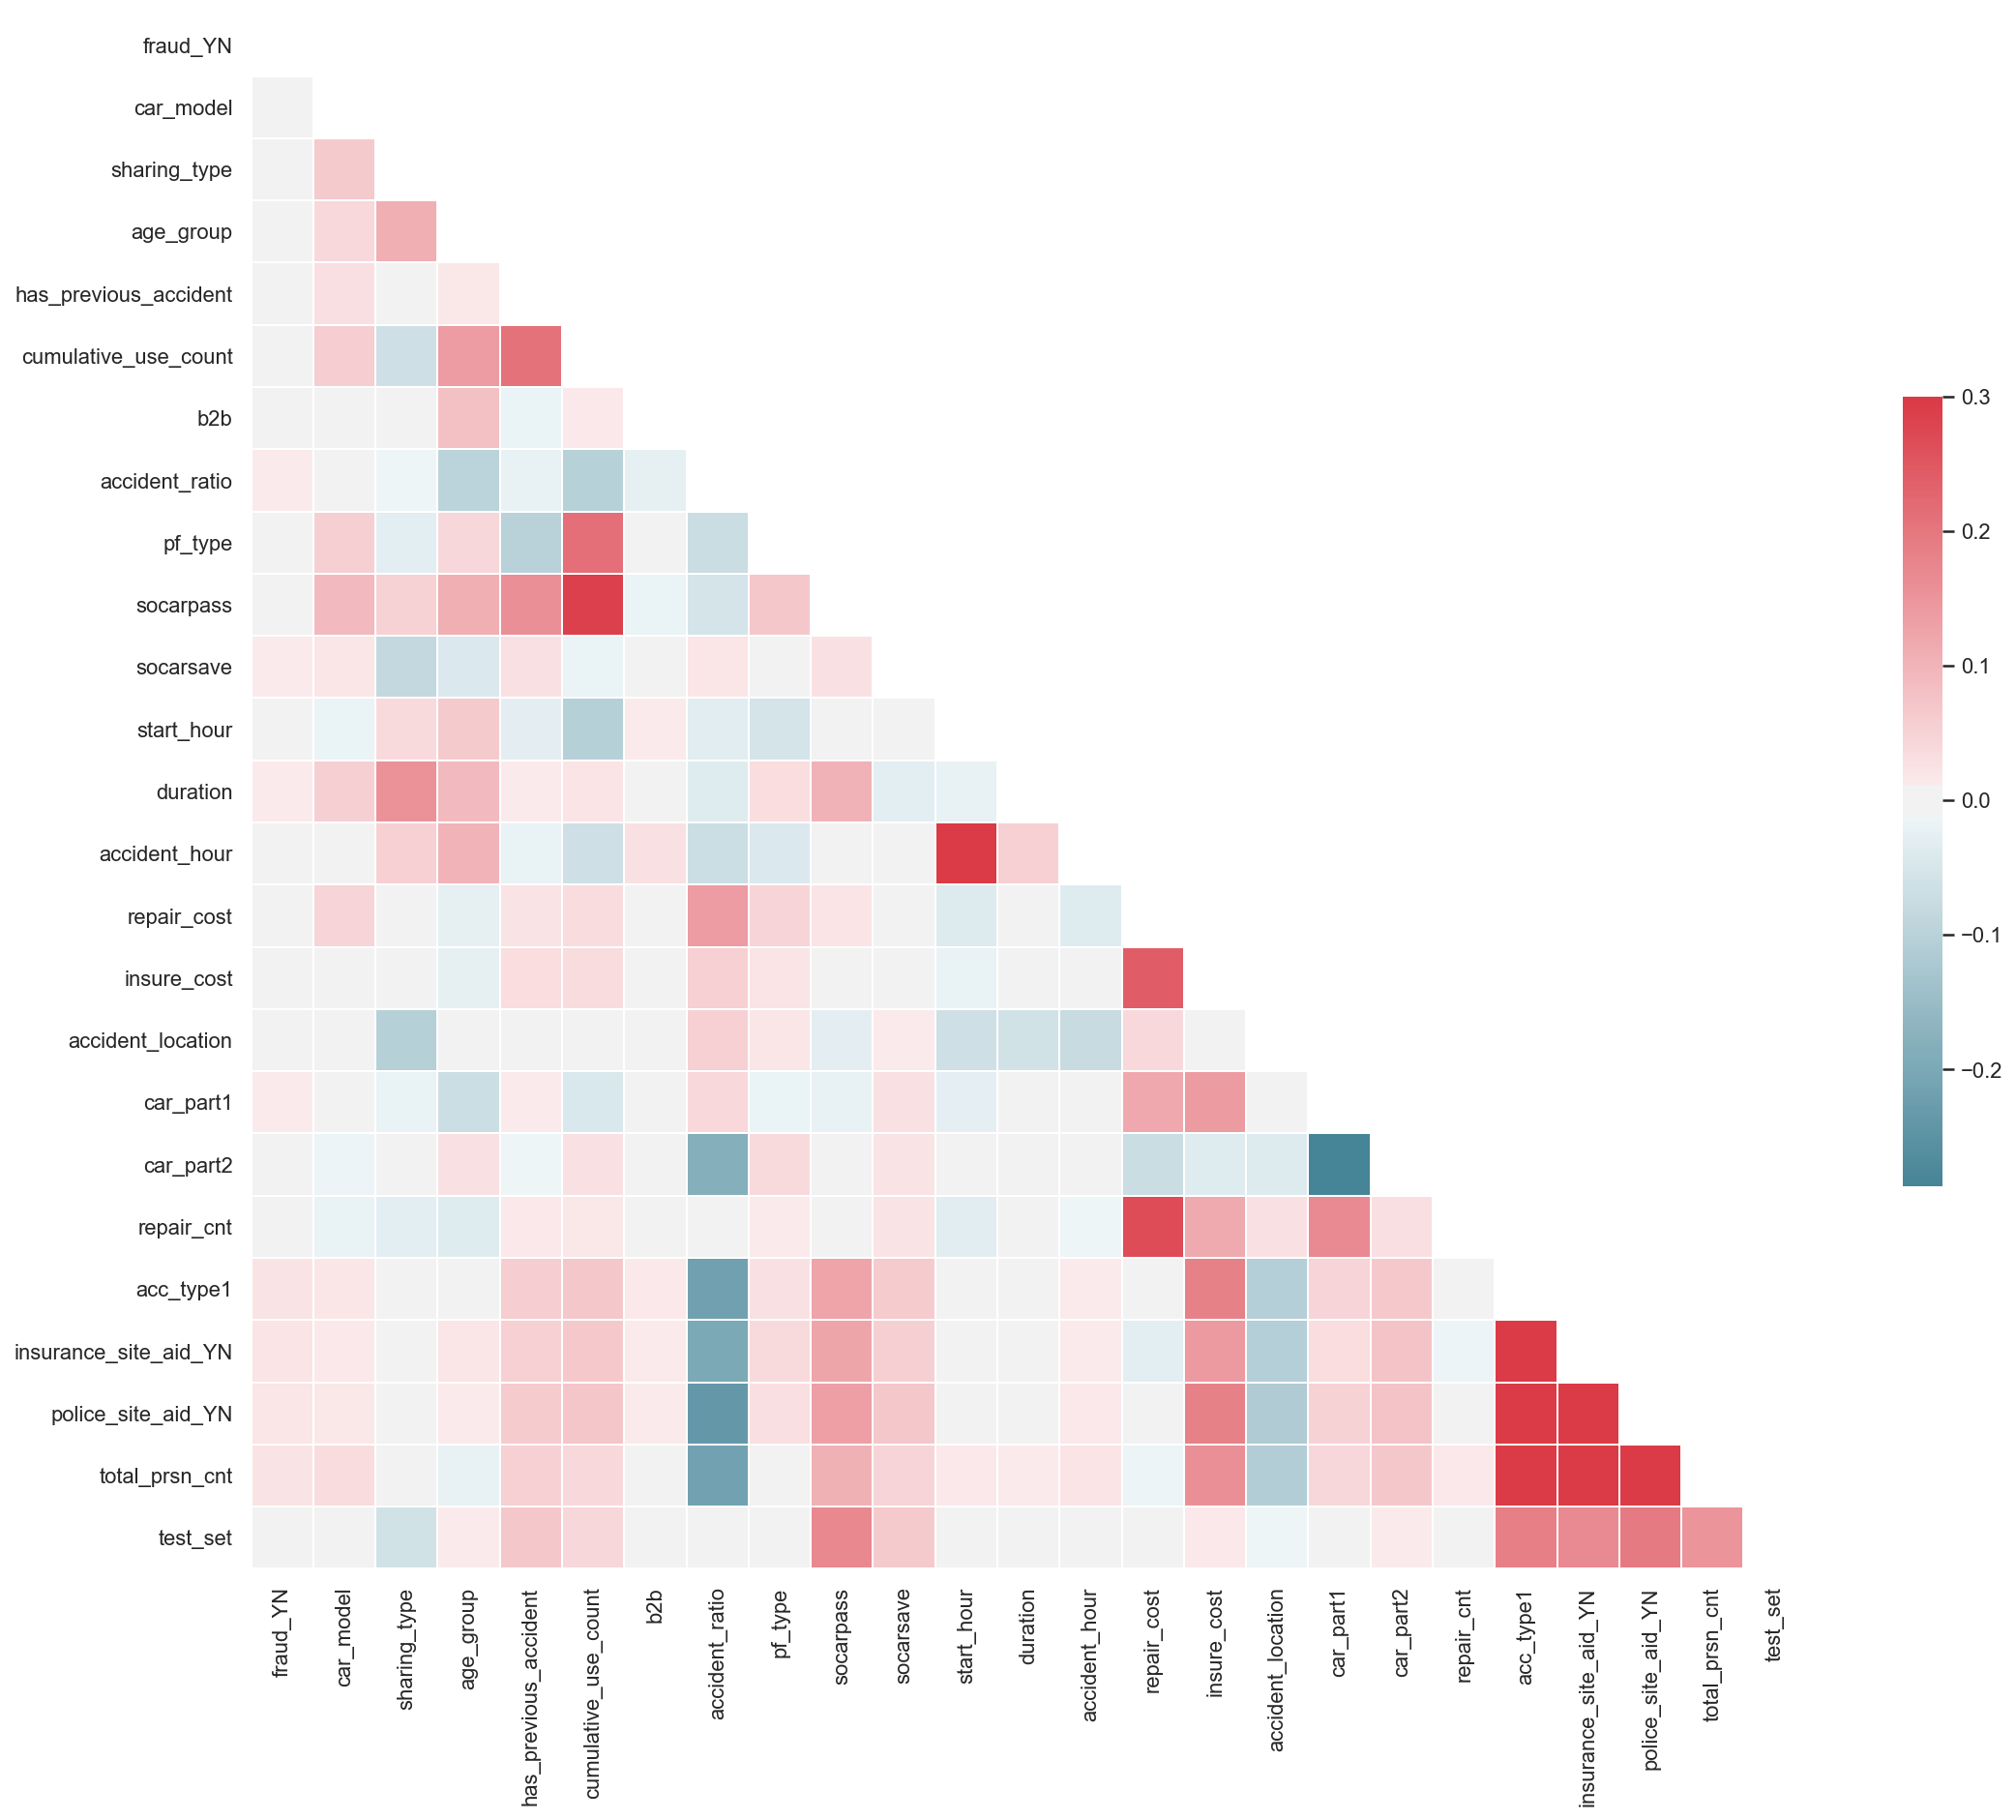

In [18]:
mask = np.zeros_like(socar.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(socar.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

- 사기 유무와 직접적으로 높은 상관관계를 갖는 feature는 없음

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame({"VIF Factor": [variance_inflation_factor(socar.values, idx) 
                             for idx in range(socar.shape[1])], "features": socar.columns})

,VIF Factor,features
0,1.004691,fraud_YN
1,5.635391,car_model
2,1.245376,sharing_type
3,5.668244,age_group
4,1.189571,has_previous_accident
5,6.635296,cumulative_use_count
6,1.015653,b2b
7,7.958630,accident_ratio
8,6.406787,pf_type
9,1.380620,socarpass


- acc_type1과 police_site_aid_YN이 높은 상관관계를 보임 -> 둘 중 하나를 drop해보는 것도 시도해볼 예정

## function

In [58]:
def make_graph(column):
    fig,ax = plt.subplots(2, 2, figsize=(20,12))

    t0 = socar[socar['fraud_YN']==0]
    t1 = socar[socar['fraud_YN']==1]


    plt.subplot(2,2,1)
    ax0 = sns.countplot(column, data=socar[socar['fraud_YN']==0])
    for p in ax0.patches:
        count = p.get_height()
        x = p.get_x() 
        y = p.get_y() + p.get_height()
        ax0.annotate(count, (x, y))
    plt.title("non-fraud {}".format(column))    

    plt.subplot(2,2,2)
    ax1 = sns.countplot(column, data=socar[socar['fraud_YN']==1])
    for p in ax1.patches:
        count = p.get_height()
        x = p.get_x() + 0.3
        y = p.get_y() + p.get_height()
        ax1.annotate(count, (x, y))
    plt.title("fraud {}".format(column))    

    plt.subplot(2,2,3)
    socar_df[socar_df['fraud_YN']==1][column].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title("fraud {}".format(column))    

    plt.subplot(2,2,4)
    sns.kdeplot(t0[column], bw=0.5, label = 'non-fraud')
    sns.kdeplot(t1[column], bw=0.5, label = 'fraud')
    plt.title("fraud vs non-fraud")   

    plt.show()

## 01.accident_ratio
사고 과실율

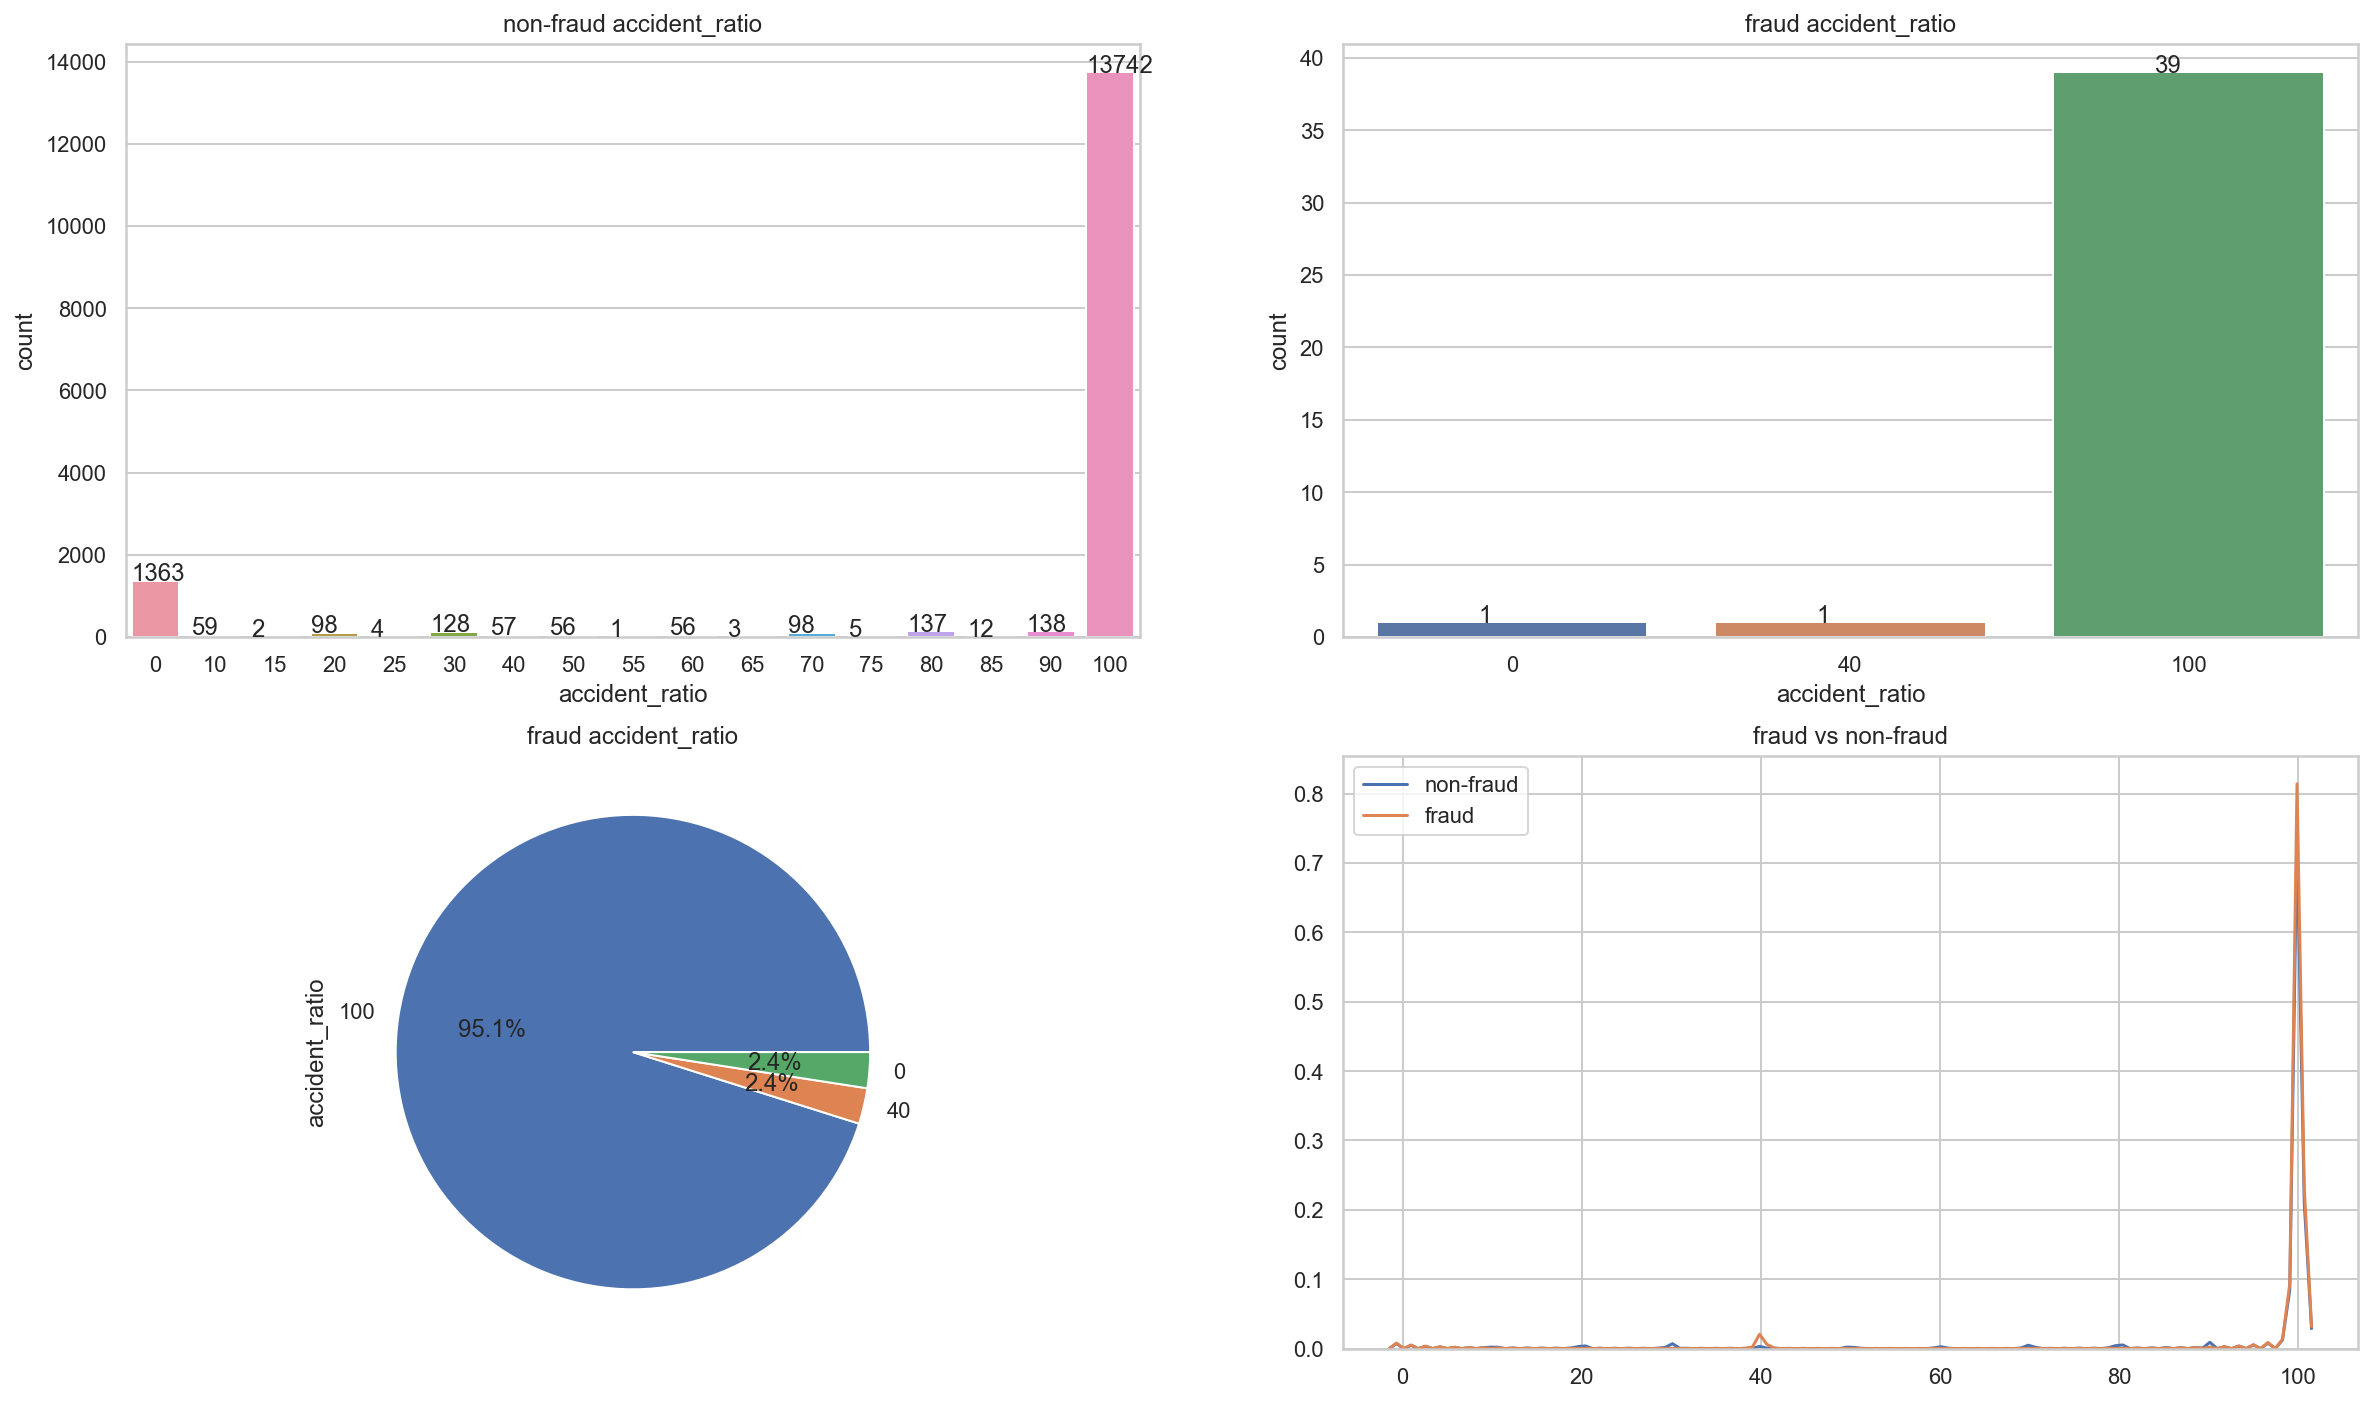

In [32]:
make_graph('accident_ratio')

- 과실율 0, 100인 데이터가 90% 이상 분포되어 있음
- fraud 데이터의 경우 과실율 100%인 case의 비율이 더 높고 0, 40이 1건씩 존재함
- 과실율 40%인 데이터 1건은 이상치로 판단되고 다양한 방식으로 전처리가 필요해 보임

## 02.pf_type
보험료(자기부담금)
    1. 자기부담금 5만원 (보험료 상)
    2. 자기부담금 30만원 (보험료 중)
    3. 자기부담금 70만원 (보험료 하)

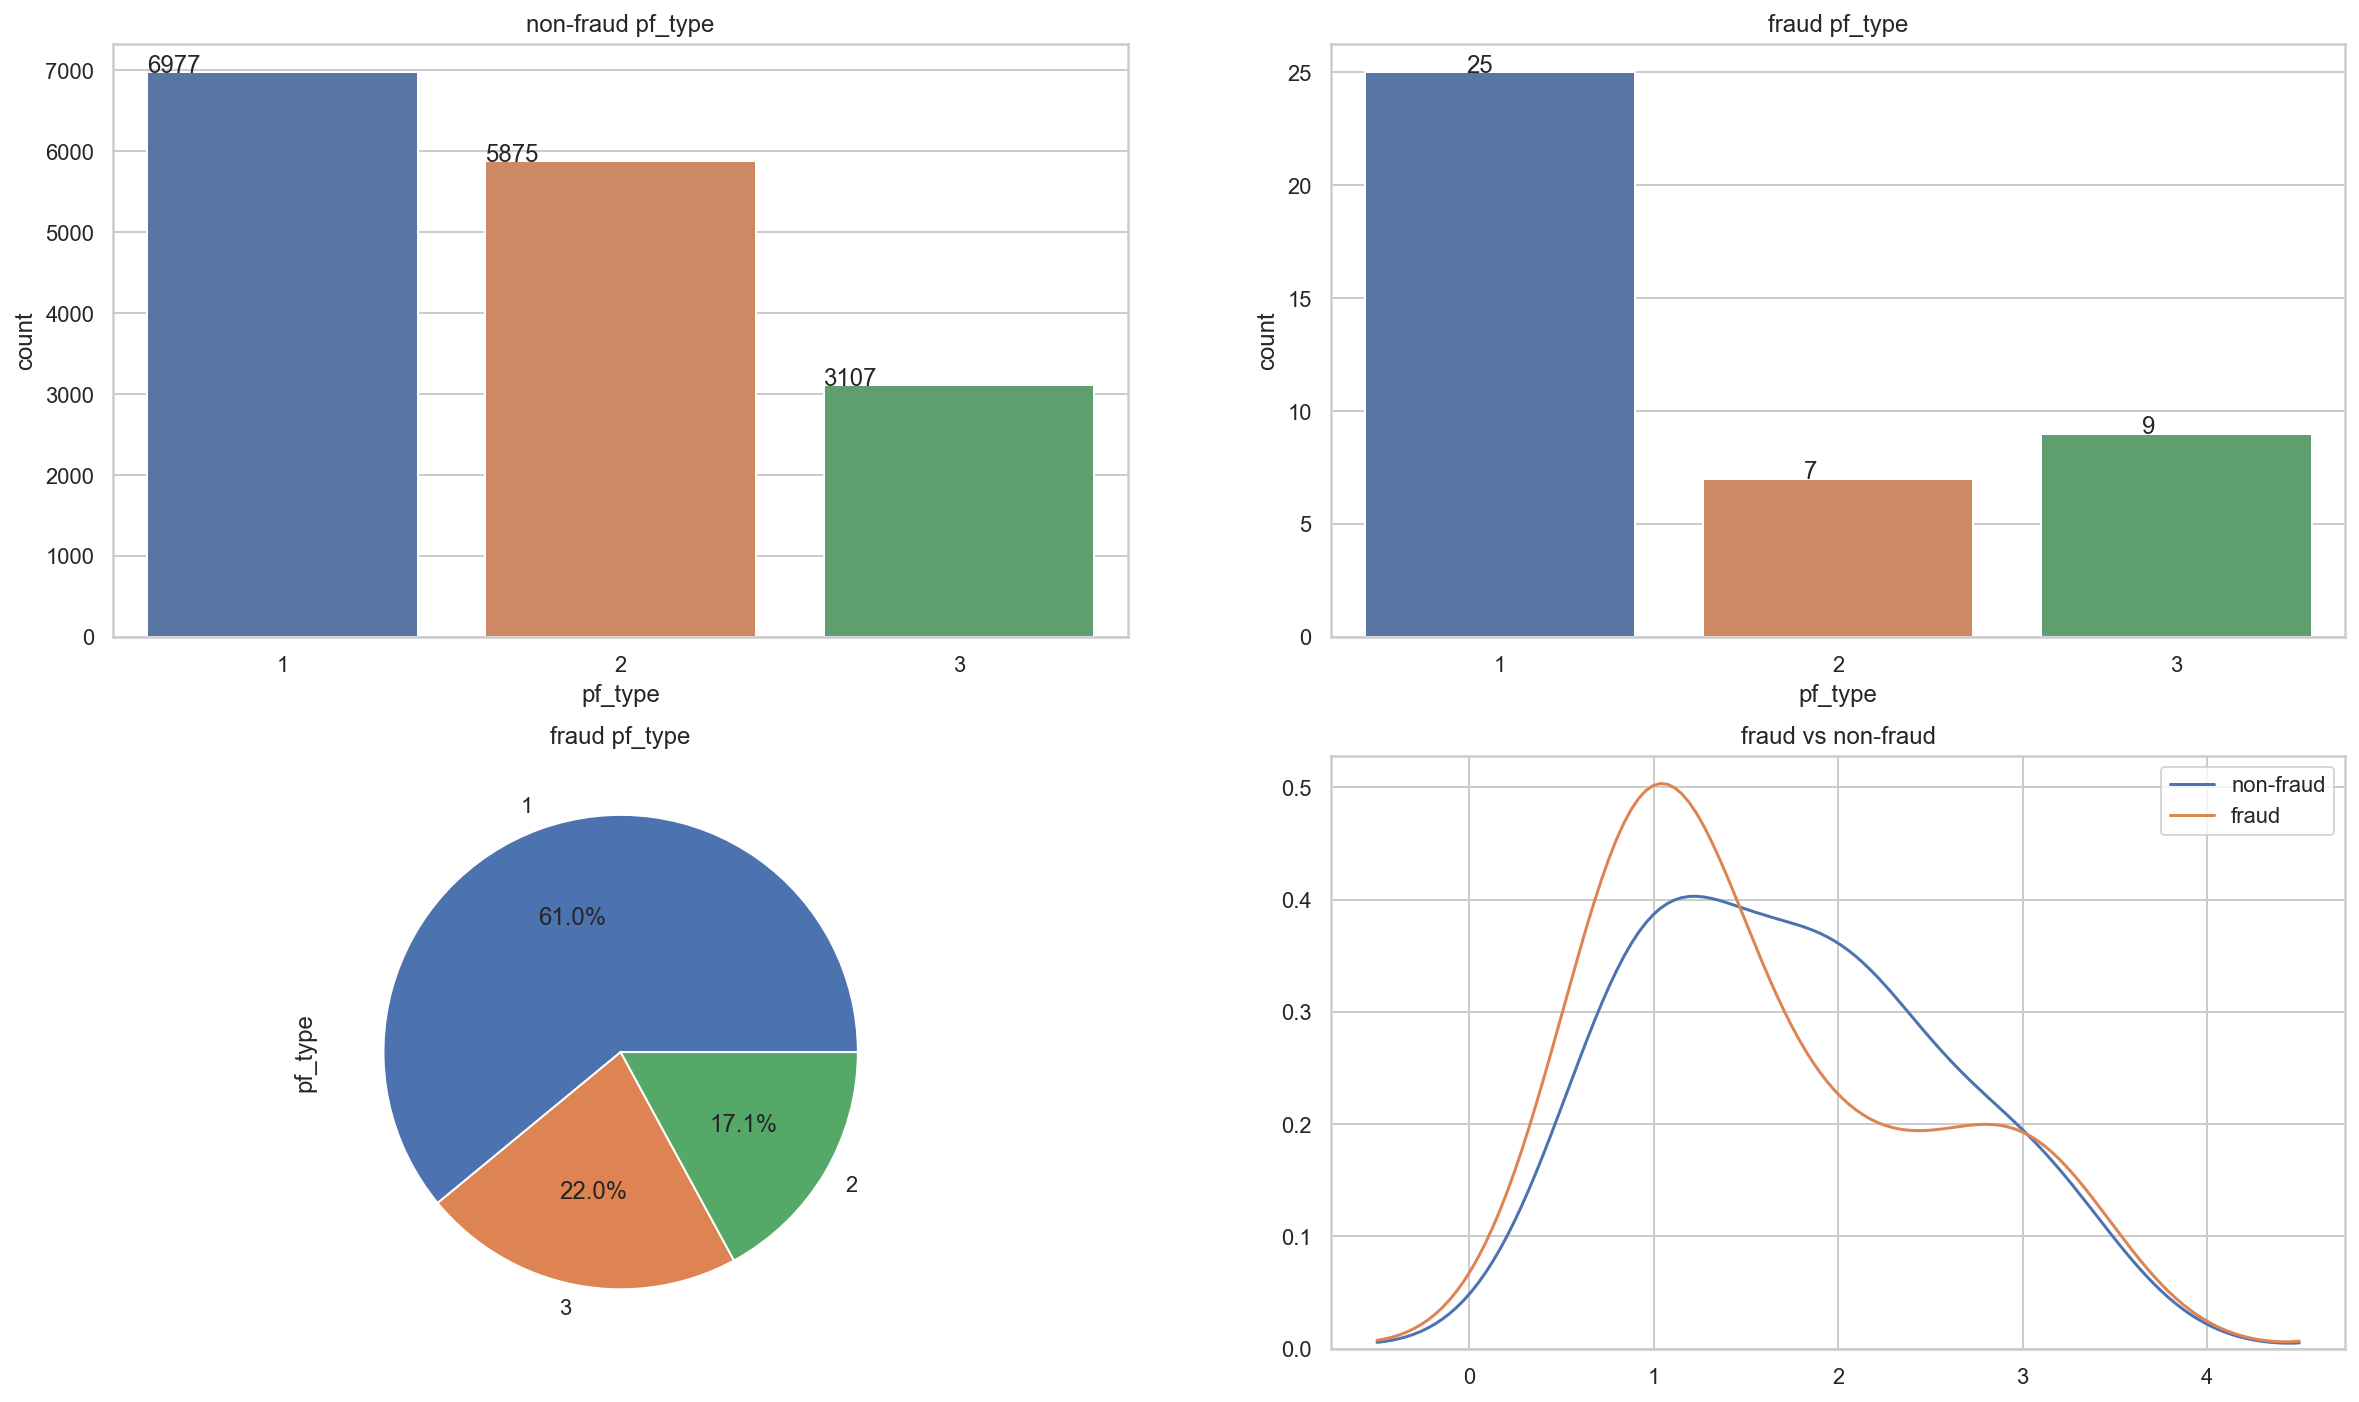

In [60]:
make_graph('pf_type')

- fraud 데이터의 경우 보험료가 높은 1번 타입의 비중이 높음

## 03.insurance_site_aid_YN
보험사 현장출동 유무
- 1: 출동
- 2: 미출동
- 0: 알수없음

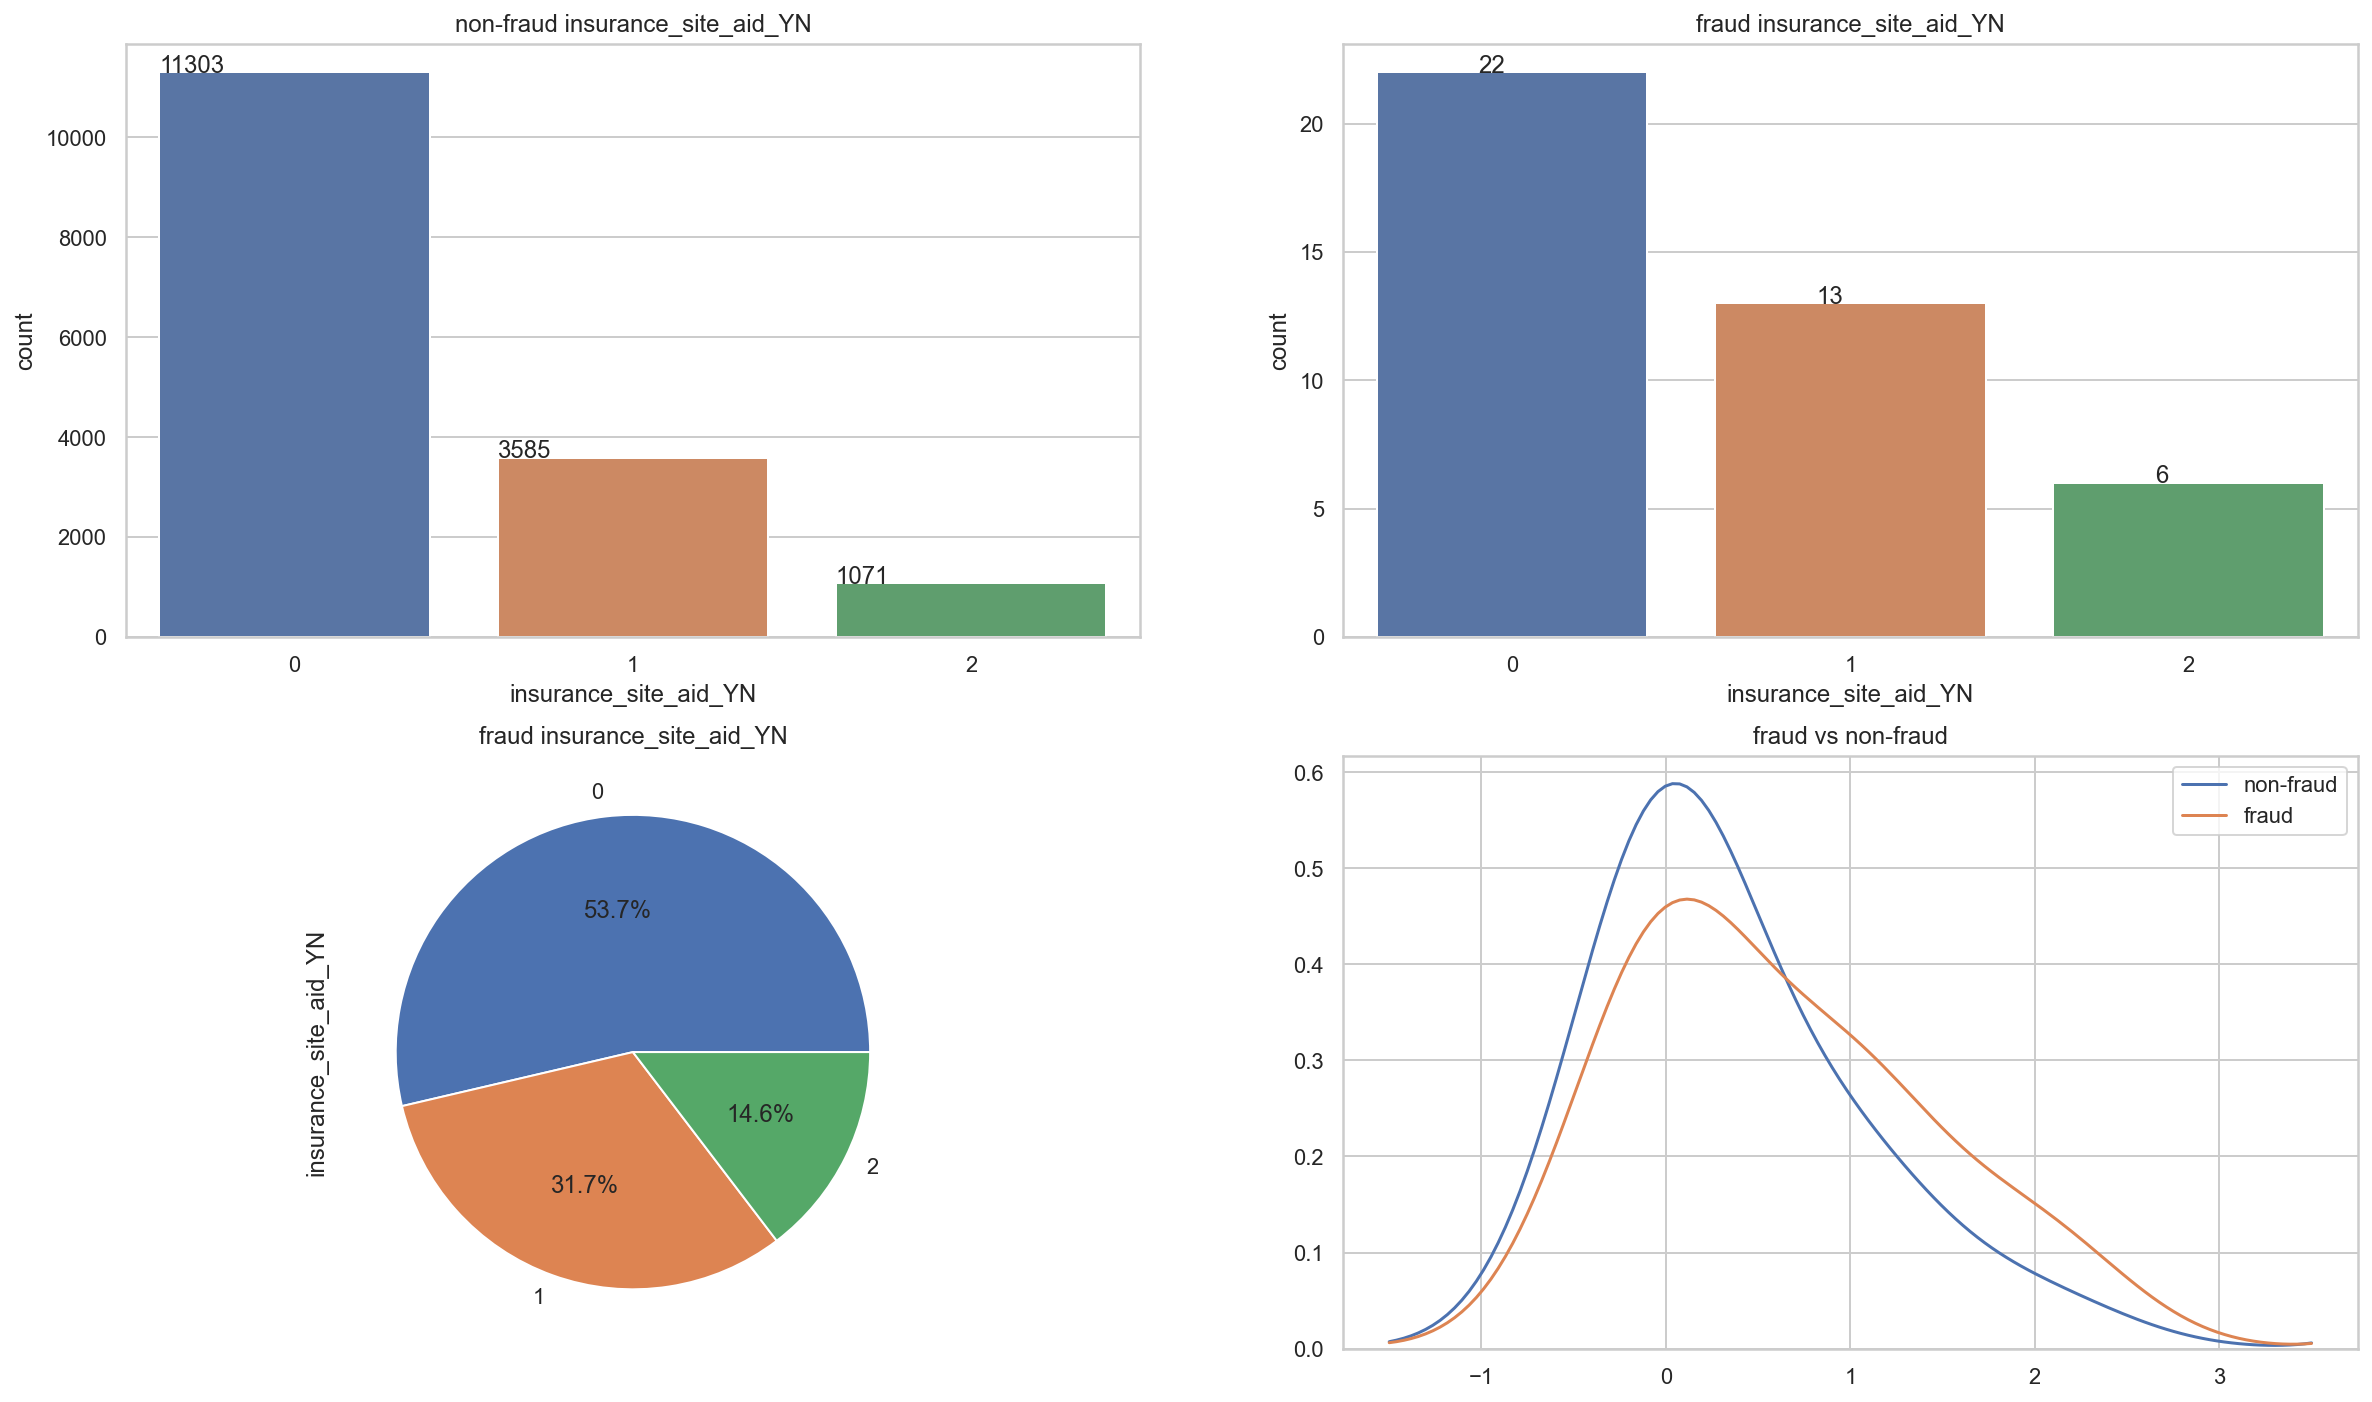

In [61]:
make_graph('insurance_site_aid_YN')

- 보험사 출동 여부 feature는 알수없음(0)의 비율이 높음 -> 어떻게 사용해야 할지에 대한 고민이 필요해 보임

## 04. police_site_aid_YN
경찰 출동 유무
- 1: 출동
- 2: 미출동
- 0: 알수없음

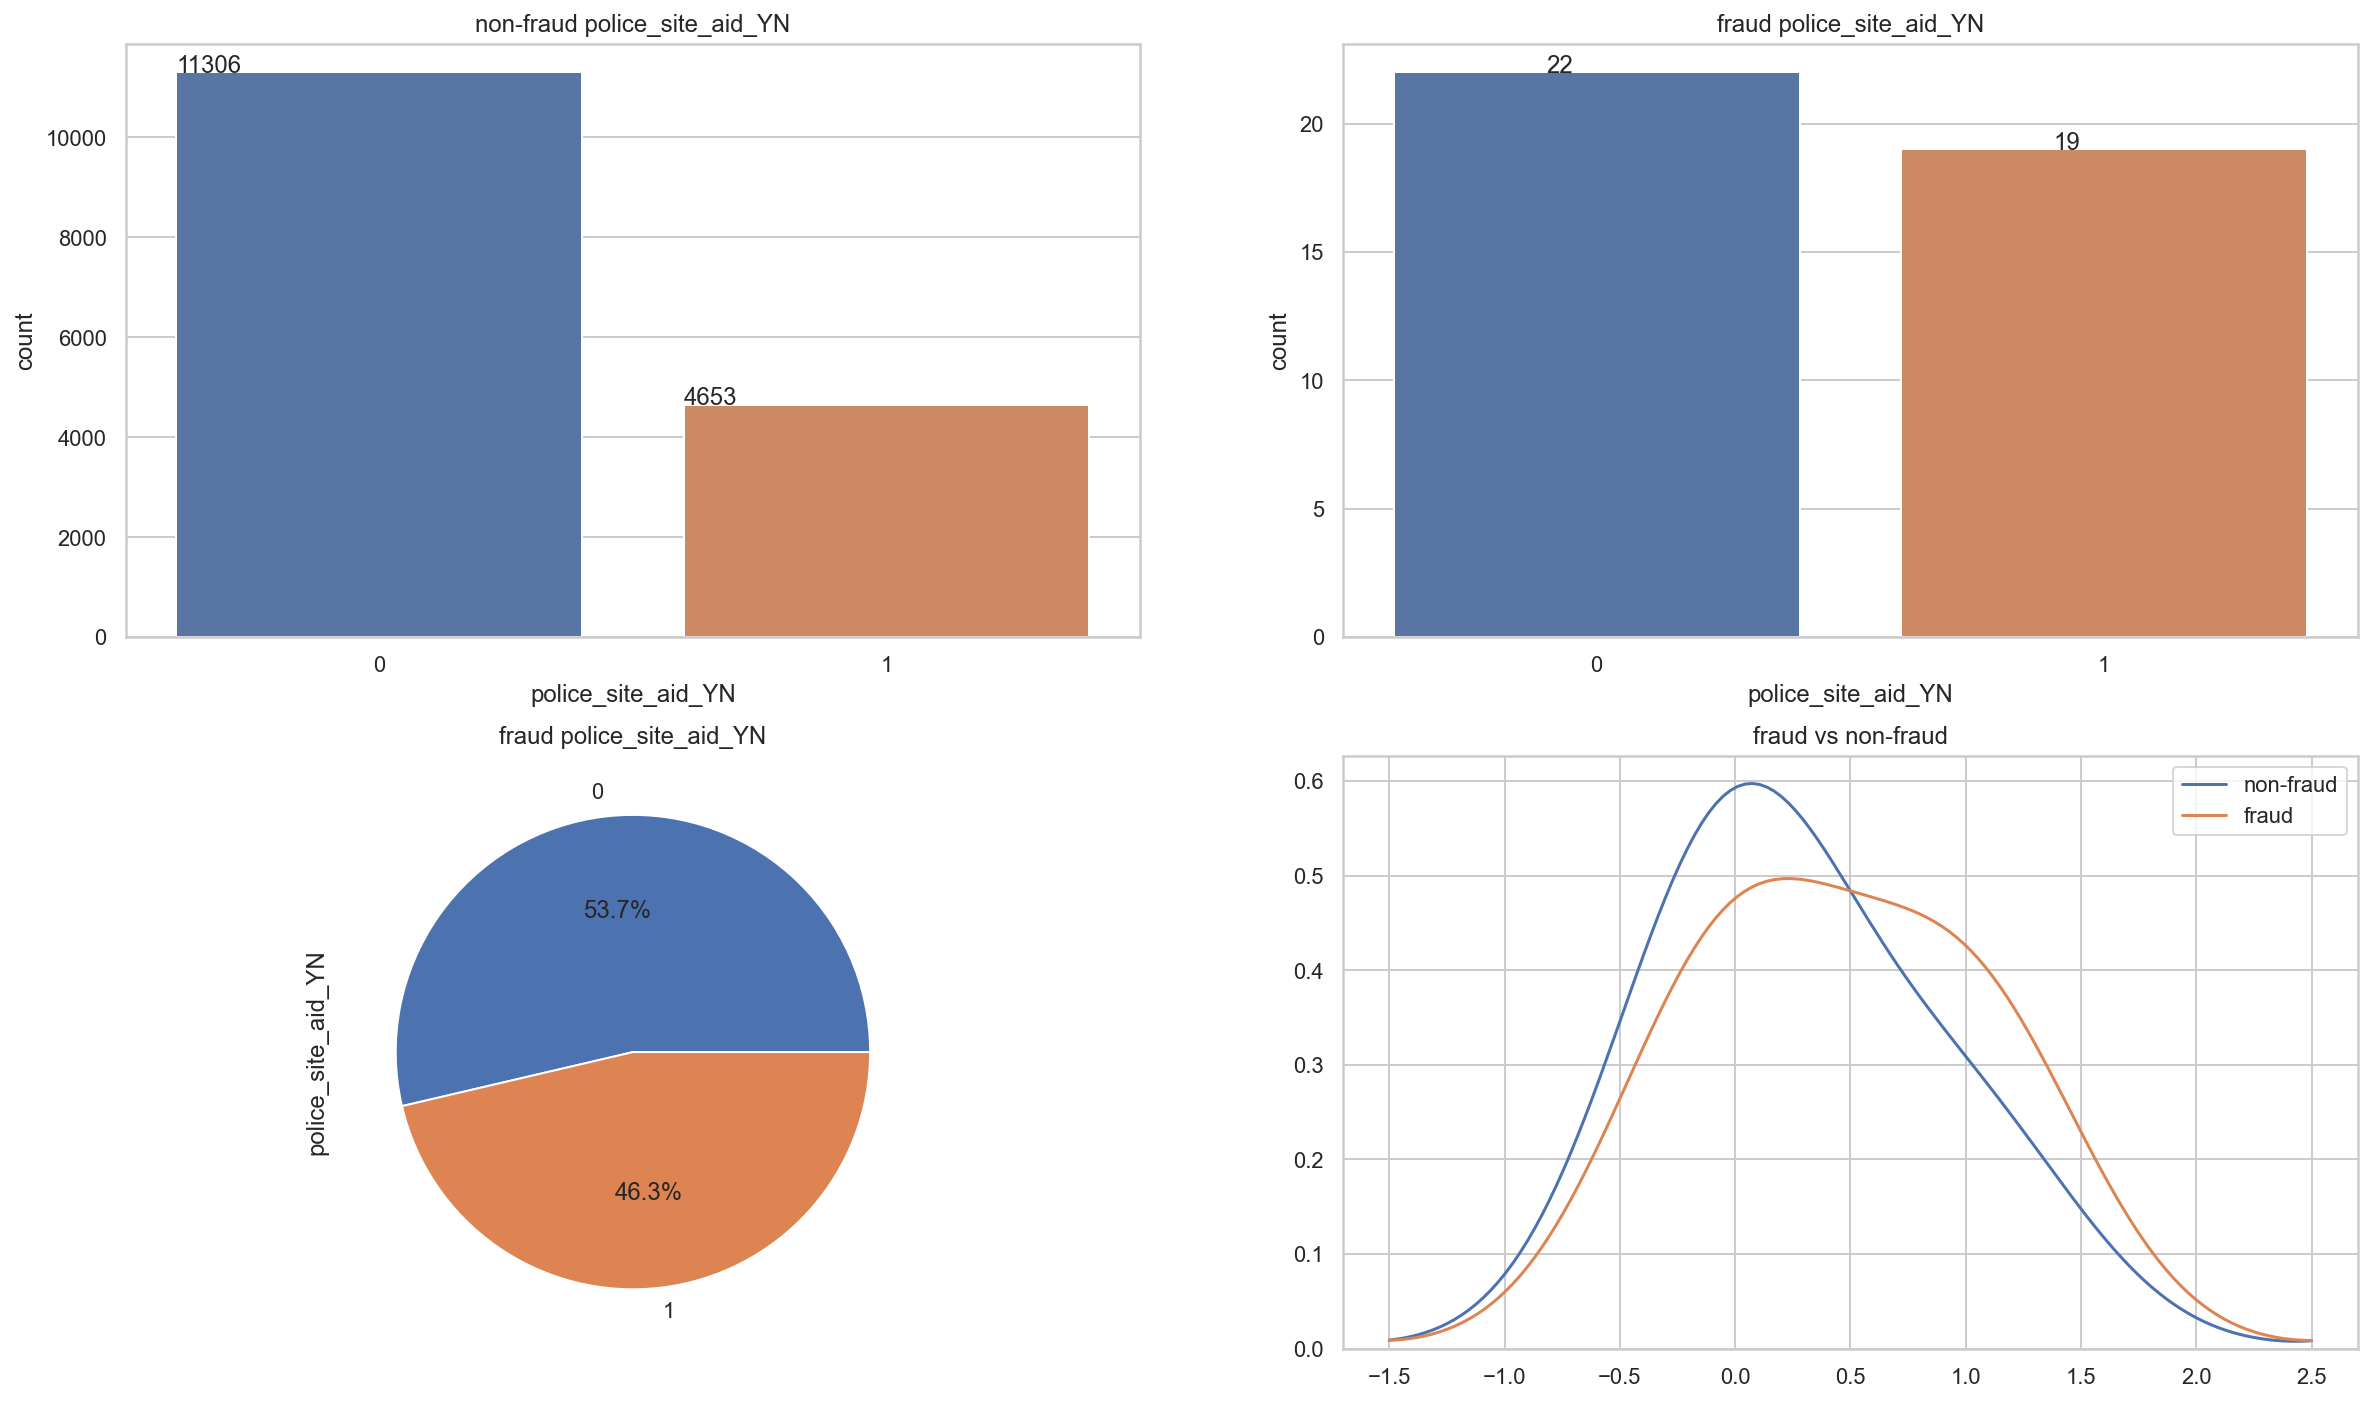

In [62]:
make_graph('police_site_aid_YN')

- 경찰 출동 여부 feature는 미출동(2)이 없고 알수없음과 출동(0,1)만 존재함
- 마찬가지로 알수없음(0)의 비율이 높음 -> 어떻게 사용해야 할지에 대한 고민이 필요해 보임

In [46]:
socar_df.groupby(by = ['police_site_aid_YN', 'insurance_site_aid_YN']).count()

fraud_YN  car_model  sharing_type  \
police_site_aid_YN insurance_site_aid_YN                                      
0                  0                         11325      11325         11325   
                   1                             3          3             3   
1                  1                          3595       3595          3595   
                   2                          1077       1077          1077   

                                          age_group  has_previous_accident  \
police_site_aid_YN insurance_site_aid_YN                                     
0                  0                          11325                  11325   
                   1                              3                      3   
1                  1                           3595                   3595   
                   2                           1077                   1077   

                                          cumulative_use_count    b2b  \
police_site_aid_YN insurance_site_aid_YN                                
0                  0                                     11325  11325   
                   1                                         3      3   
1                  1                                      3595   3595   
                   2                                      1077   1077   

                                          accident_ratio  pf_type  socarpass  \
police_site_aid_YN insurance_site_aid_YN                                       
0                  0                               11325    11325      11325   
                   1                                   3        3          3   
1                  1                                3595     3595       3595   
                   2                                1077     1077       1077   

                                          socarsave  start_hour  duration  \
police_site_aid_YN insurance_site_aid_YN                                    
0                  0                          11325       11325     11325   
                   1                              3           3         3   
1                  1                           3595        3595      3595   
                   2                           1077        1077      1077   

                                          accident_hour  repair_cost  \
police_site_aid_YN insurance_site_aid_YN                               
0                  0                              11325        11325   
                   1                                  3            3   
1                  1                               3595         3595   
                   2                               1077         1077   

                                          insure_cost  accident_location  \
police_site_aid_YN insurance_site_aid_YN                                   
0                  0                            11325              11325   
                   1                                3                  3   
1                  1                             3595               3595   
                   2                             1077               1077   

                                          car_part1  car_part2  repair_cnt  \
police_site_aid_YN insurance_site_aid_YN                                     
0                  0                          11325      11325       11325   
                   1                              3          3           3   
1                  1                           3595       3595        3595   
                   2                           1077       1077        1077   

                                          acc_type1  total_prsn_cnt  test_set  
police_site_aid_YN insurance_site_aid_YN                                       
0                  0                          11325           11325     11325  
                   1                              3               3         3  
1                  1                

- Police = 0 & Insurance = 1 -> 경찰 출동 여부를 알 수 없고 보험사 출동 : 3건
- Police = 0 & Insurance = 2 -> 경찰 출동 여부를 알 수 없고 보험사 출동 안 함 : 0건
- Police = 1 & Insurance = 0 -> 경찰만 출동하고 보험사 출동 여부 알 수 없음 : 0건
- 16,000건의 데이터에서 위의 case가 3건 밖에 없다는건 이상해 보인다.

## 05. total_prsn_cnt
동승자 수
- user가 입력하는 항목으로 noise 가 심한 데이터
- -1 : 알수없음

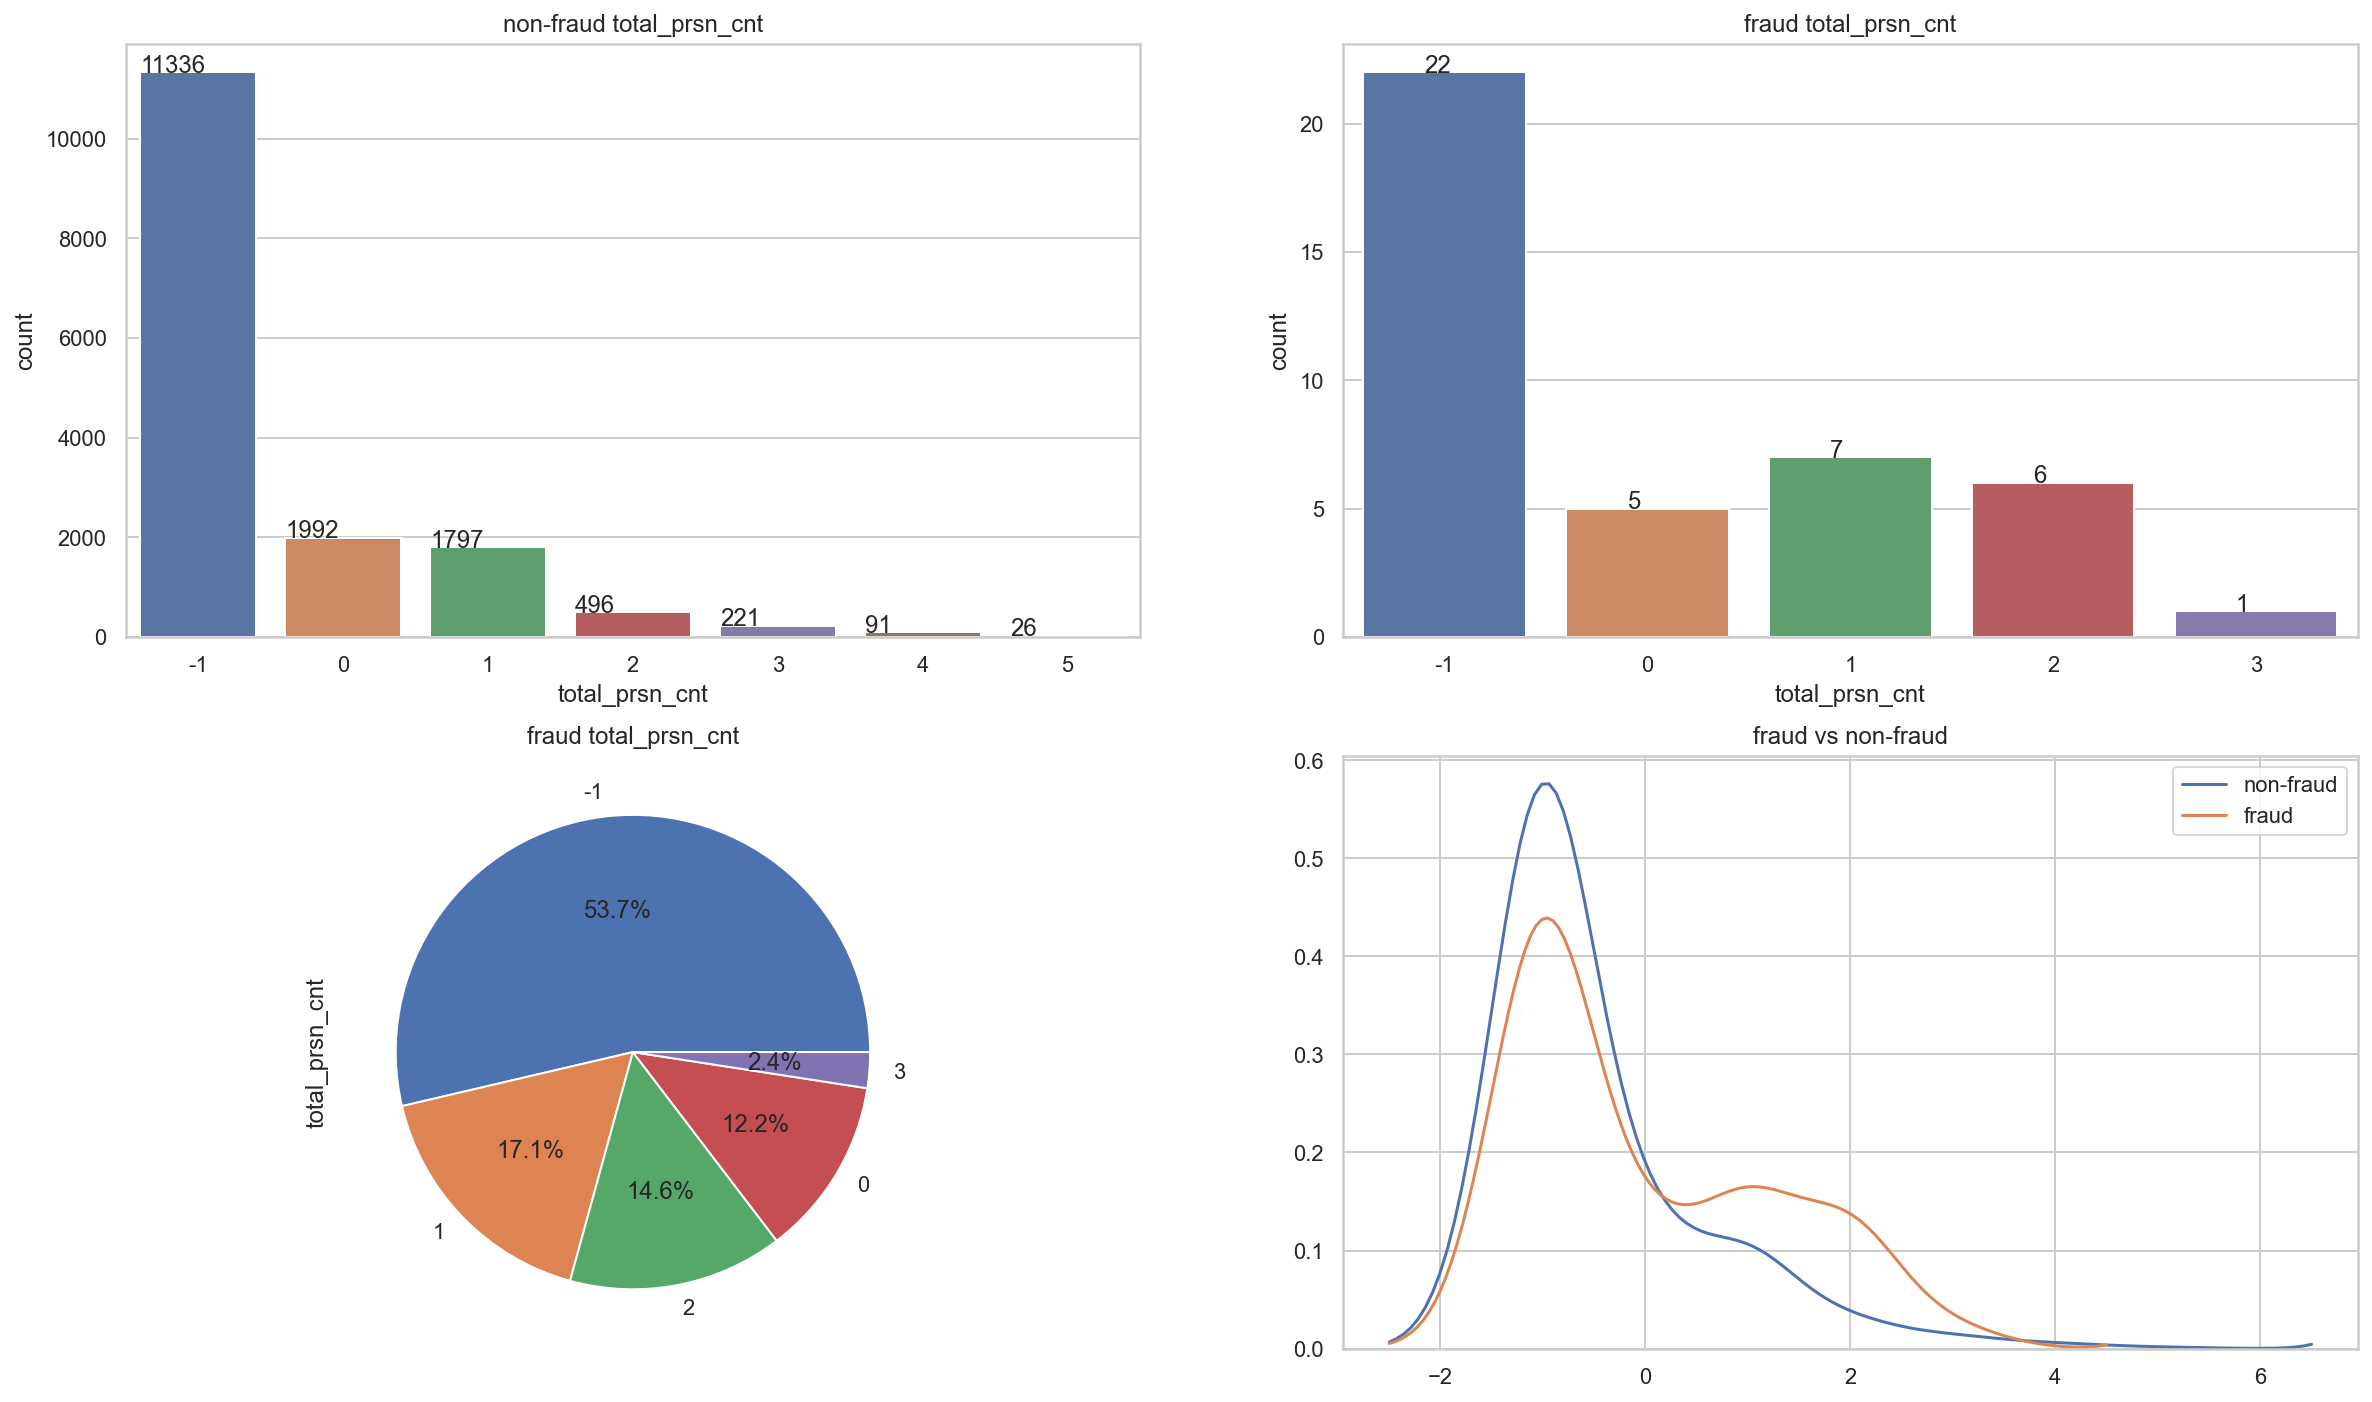

In [63]:
make_graph('total_prsn_cnt')

- 알수없음(-1)의 비율이 높음
- 동승자 수가 4명이 넘어가는 사기건은 존재하지 않음 -> 이상치로 봐야 되나 아니면 fraud 여부를 판단할 특징으로 남길까?

## 06. accident_hour
사고 시간
   - 1 : 21,22,23,0,1,2,3,4
   - 2 : 17,18,19,20
   - 3 : 5,6,7
   - 4 : 8,9,10
   - 5 : 11,12,13
   - 6 : 14,15,16
   - -1 : 설명없음

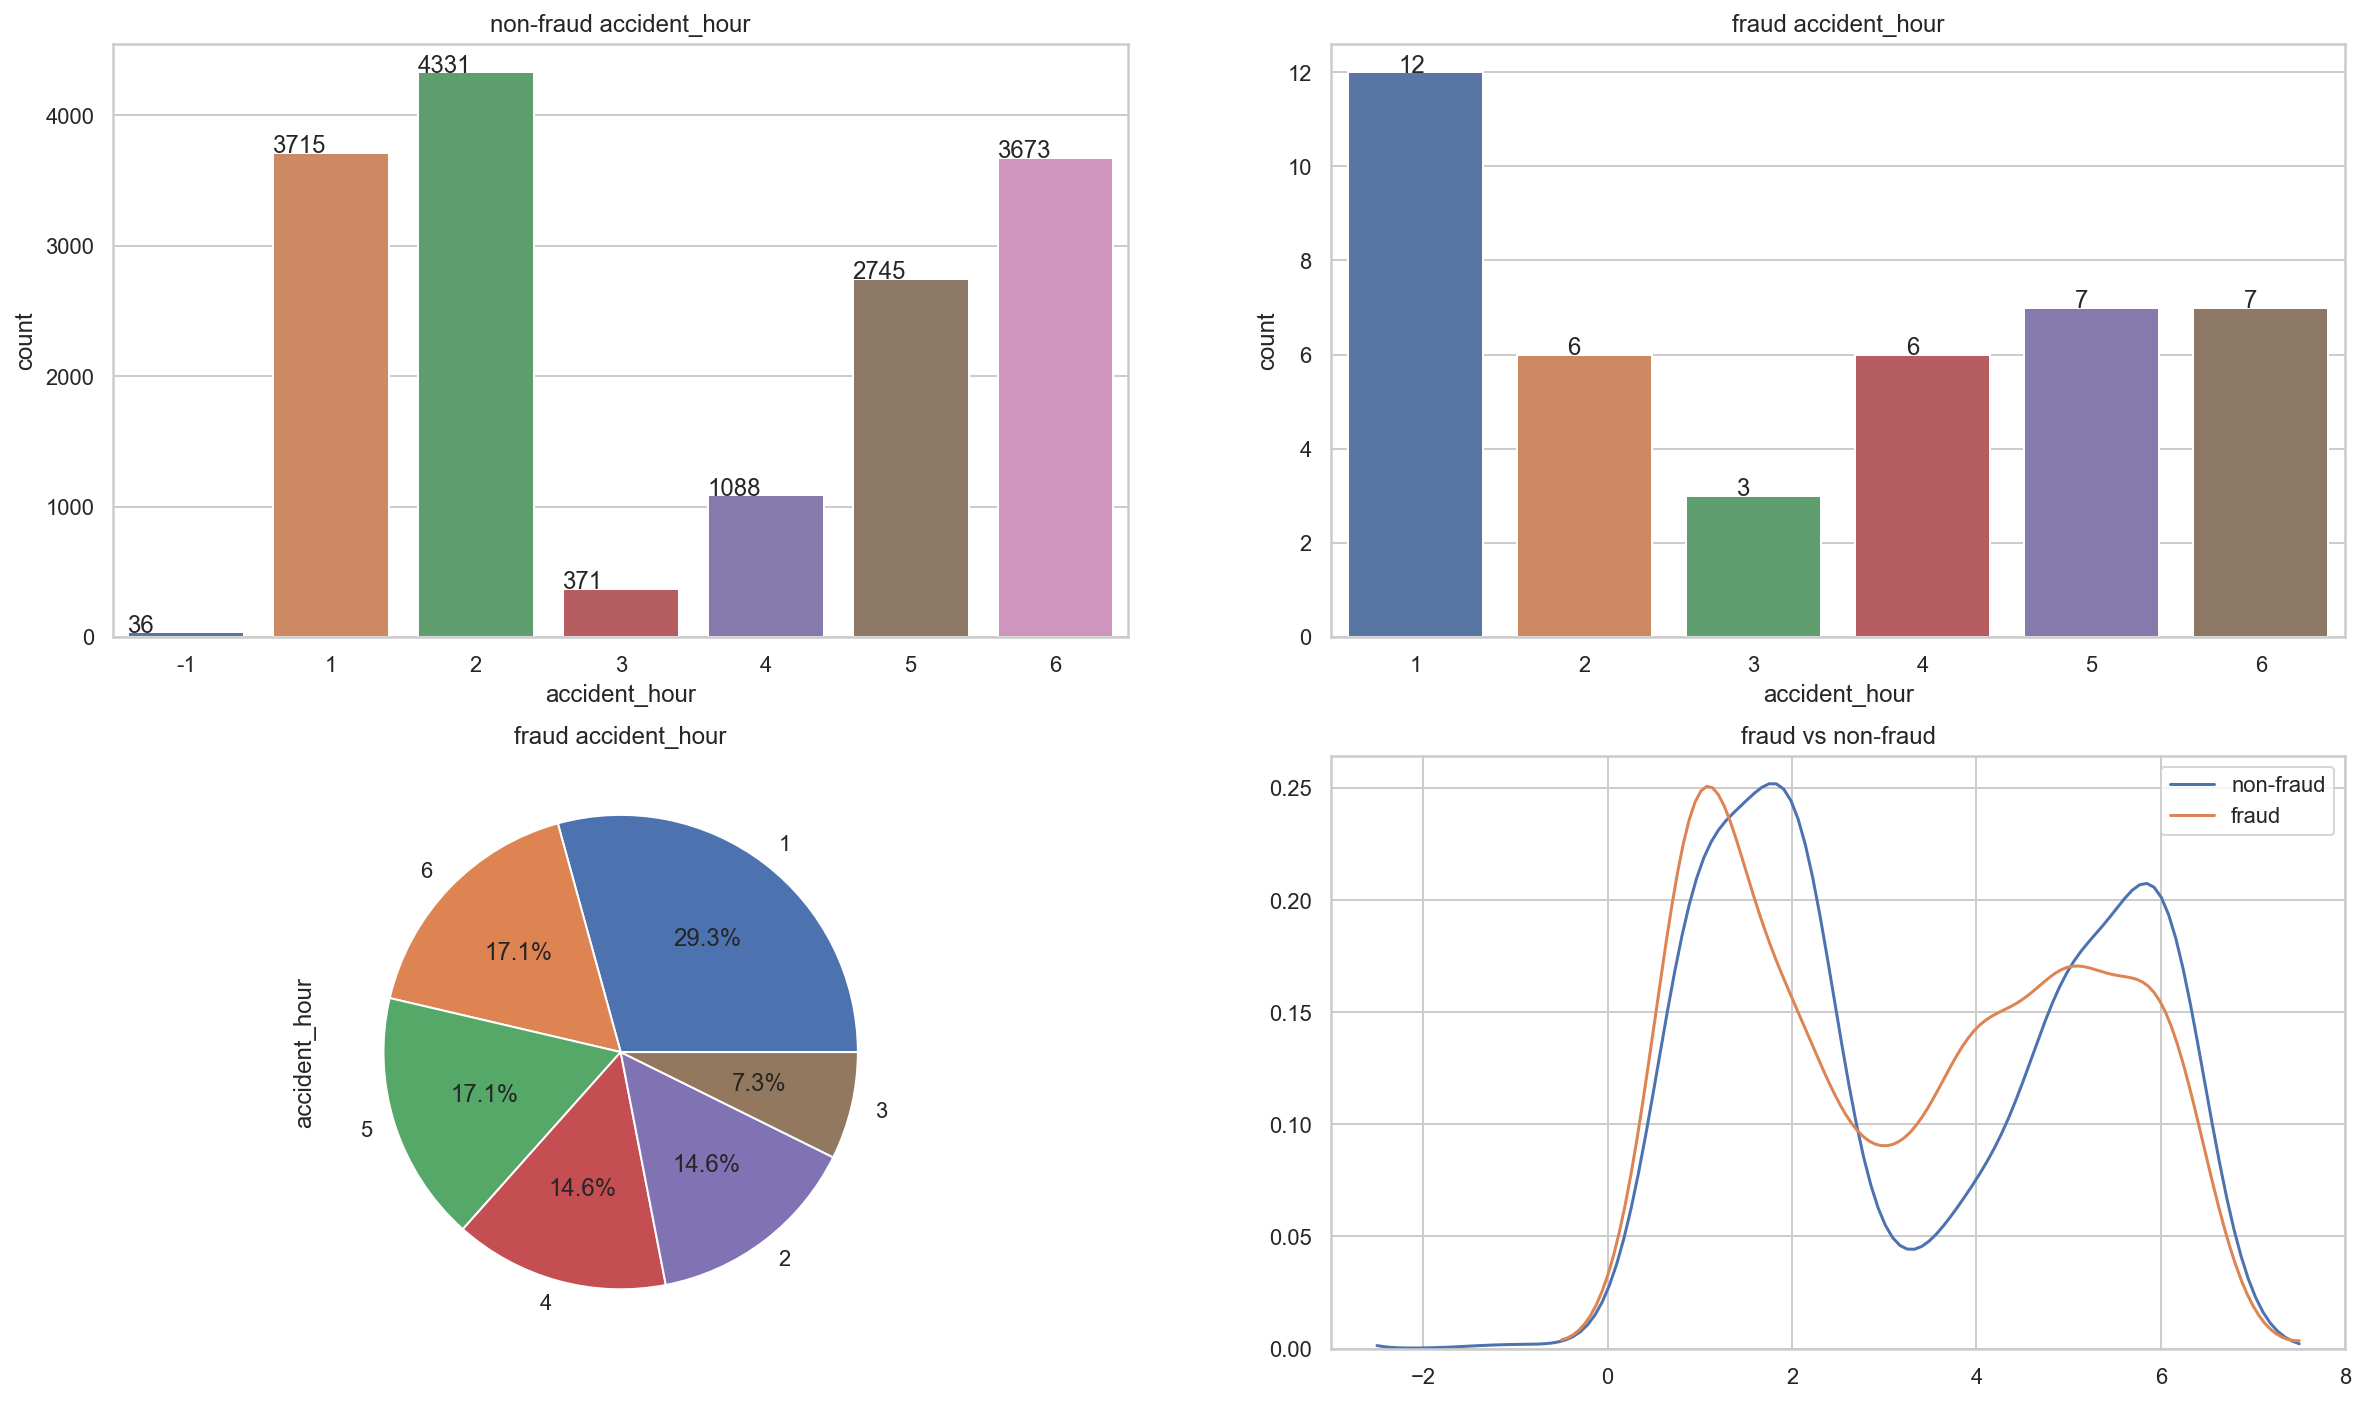

In [64]:
make_graph('accident_hour')

- fraud 데이터에는 알수없음(-1) 데이터가 없음 -> non-fraud에 알수없음(-1) 데이터는 노이즈로 판단하고 지워볼까?
- 5-8시(3), 8-11시(4)에 fraud 비율이 높음

## 07. accident_location
사고 장소
   - 0 : 주차장
   - 1 : 일반도로
   - 2 : 이면도로
   - 3 : 고속도로
   - 4 : 쏘카존
   - 5 : 확인불가

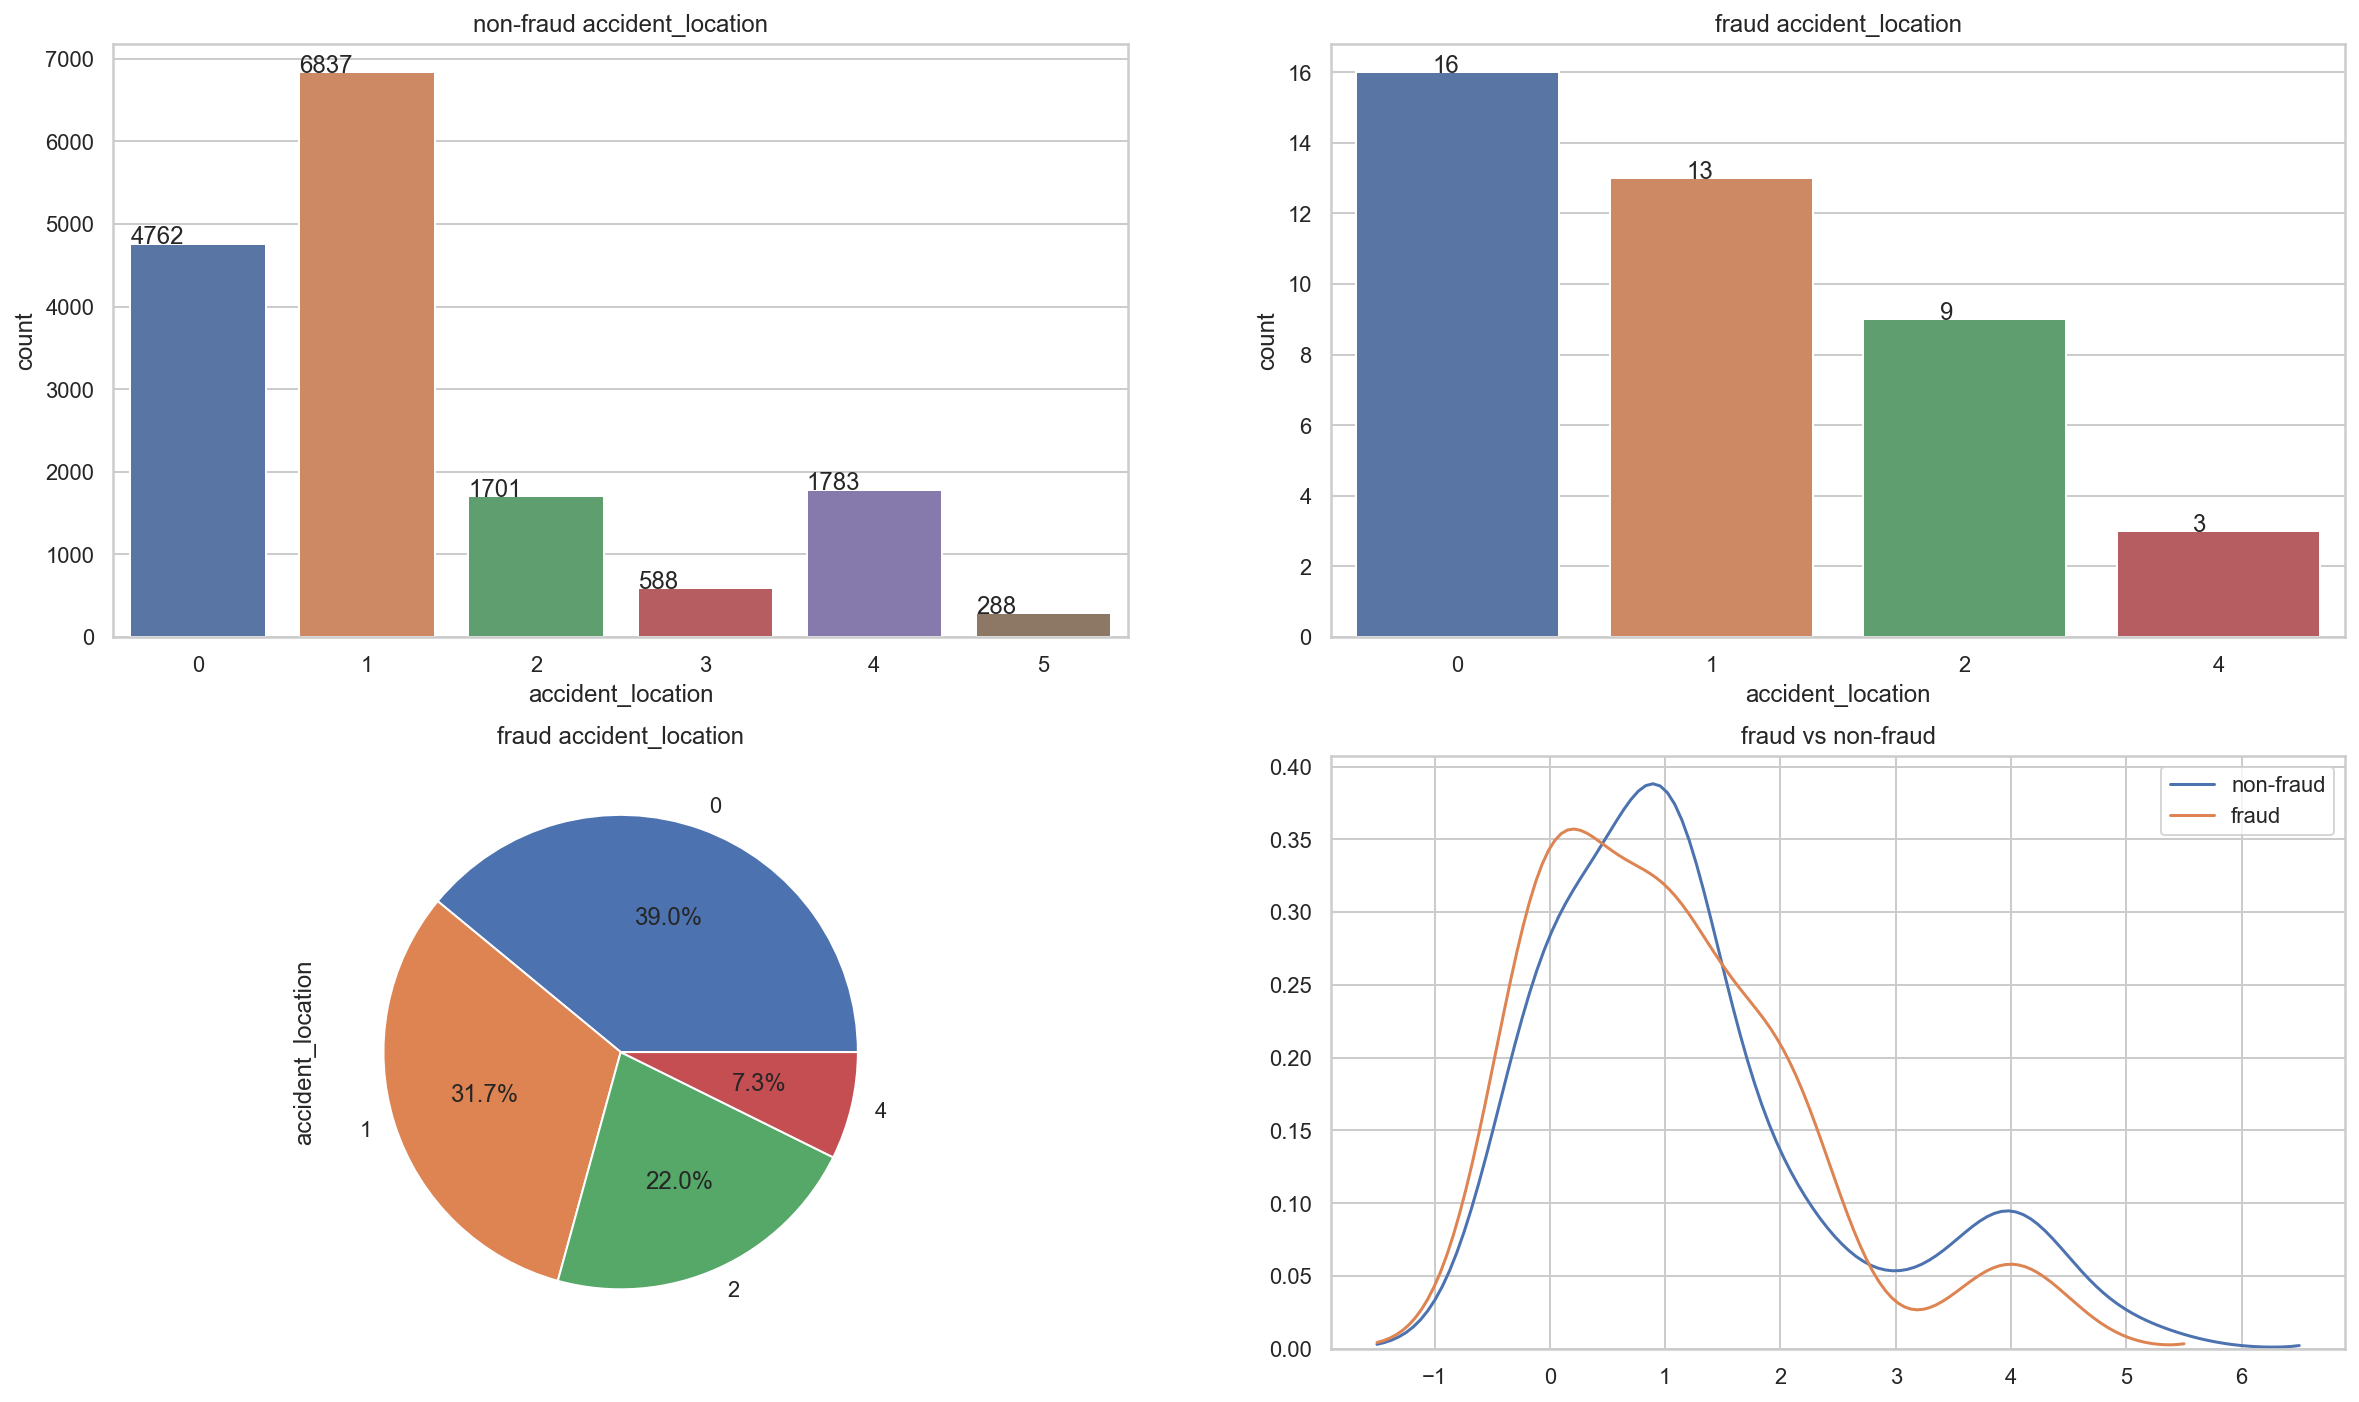

In [65]:
make_graph('accident_location')

- fraud 데이터에 고속도로 사고건(3)이 없음 -> 위험부담이 너무 크기 때문으로 추정
- accident_hour와 마찬가지로 fraud 데이터에 알수없음(5) 데이터가 없음

## 08. repair_cnt
수리 부위 개수
- 0 : 알 수 없음

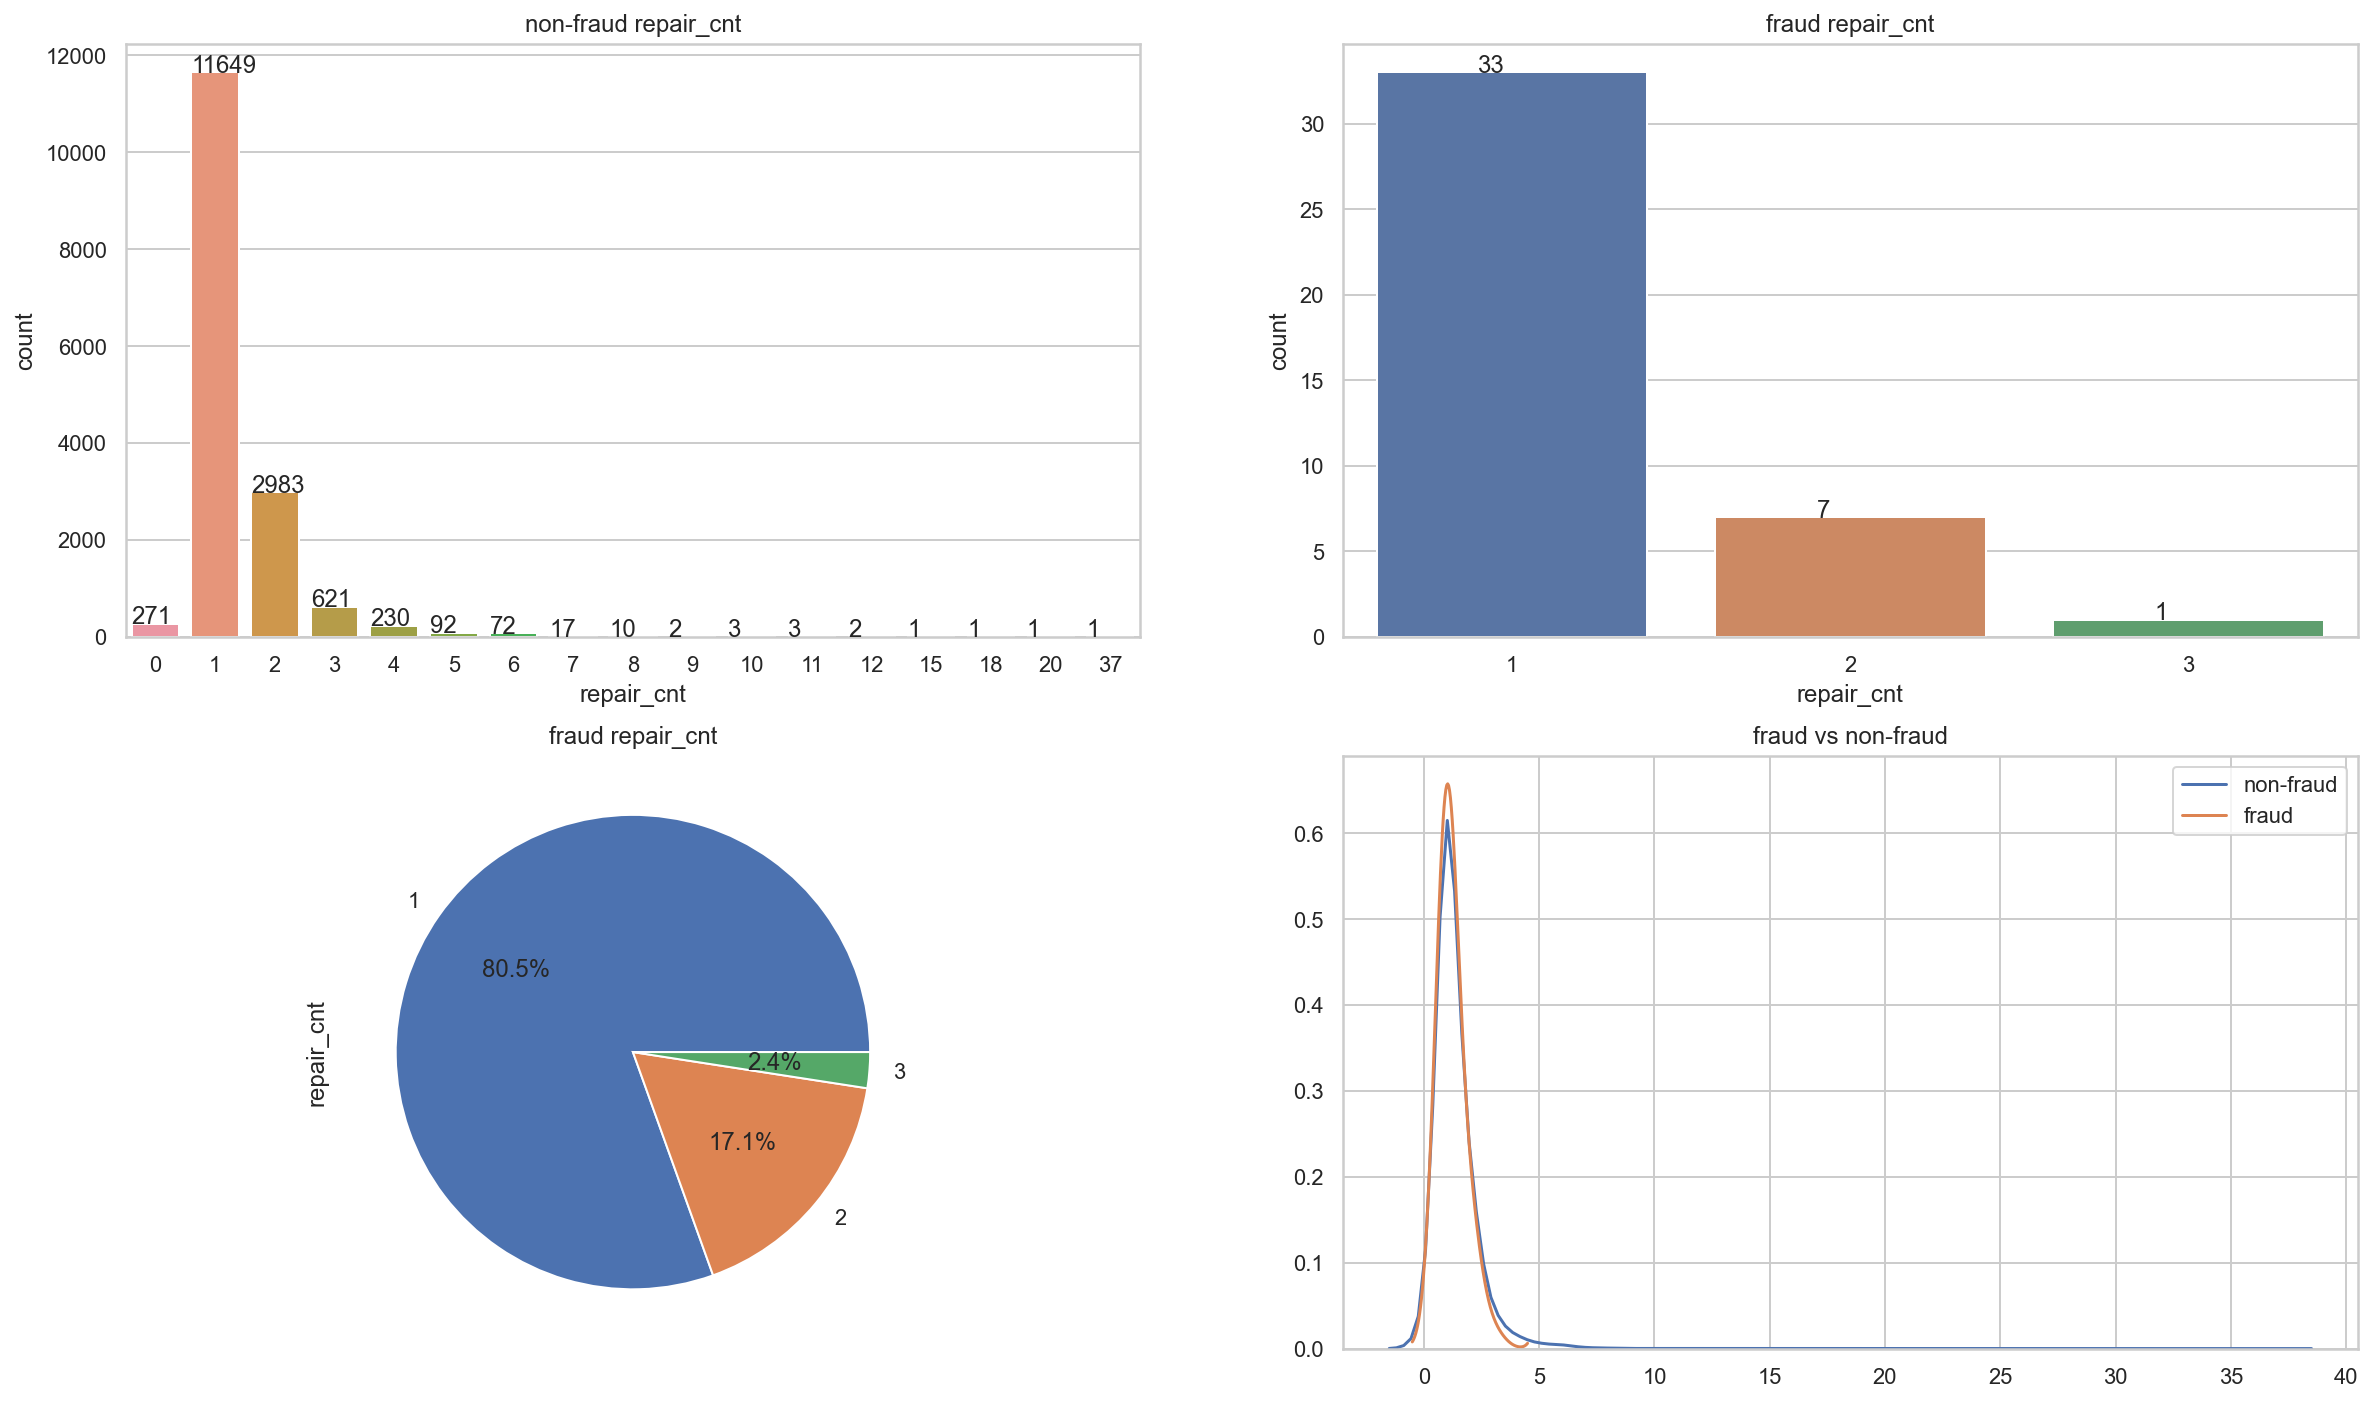

In [68]:
make_graph('repair_cnt')

- fraud 데이터의 경우 수리 부위 갯수가 3개를 넘지 않음 -> 위험한 사고는 피하는 것으로 보임
- non-fraud 데이터의 이상치에 대해서 삭제하는 것이 맞을지 fraud 여부를 결정하는 특징으로 남길지 고민해볼 필요가 있어 보임
- accident_hour와 마찬가지로 fraud 데이터에 알수없음(0) 데이터가 없음

## 09. age_group
연령대(평균)
- 1 : 21
- 2 : 23
- 3 : 27
- 4 : 31 
- 5 : 41

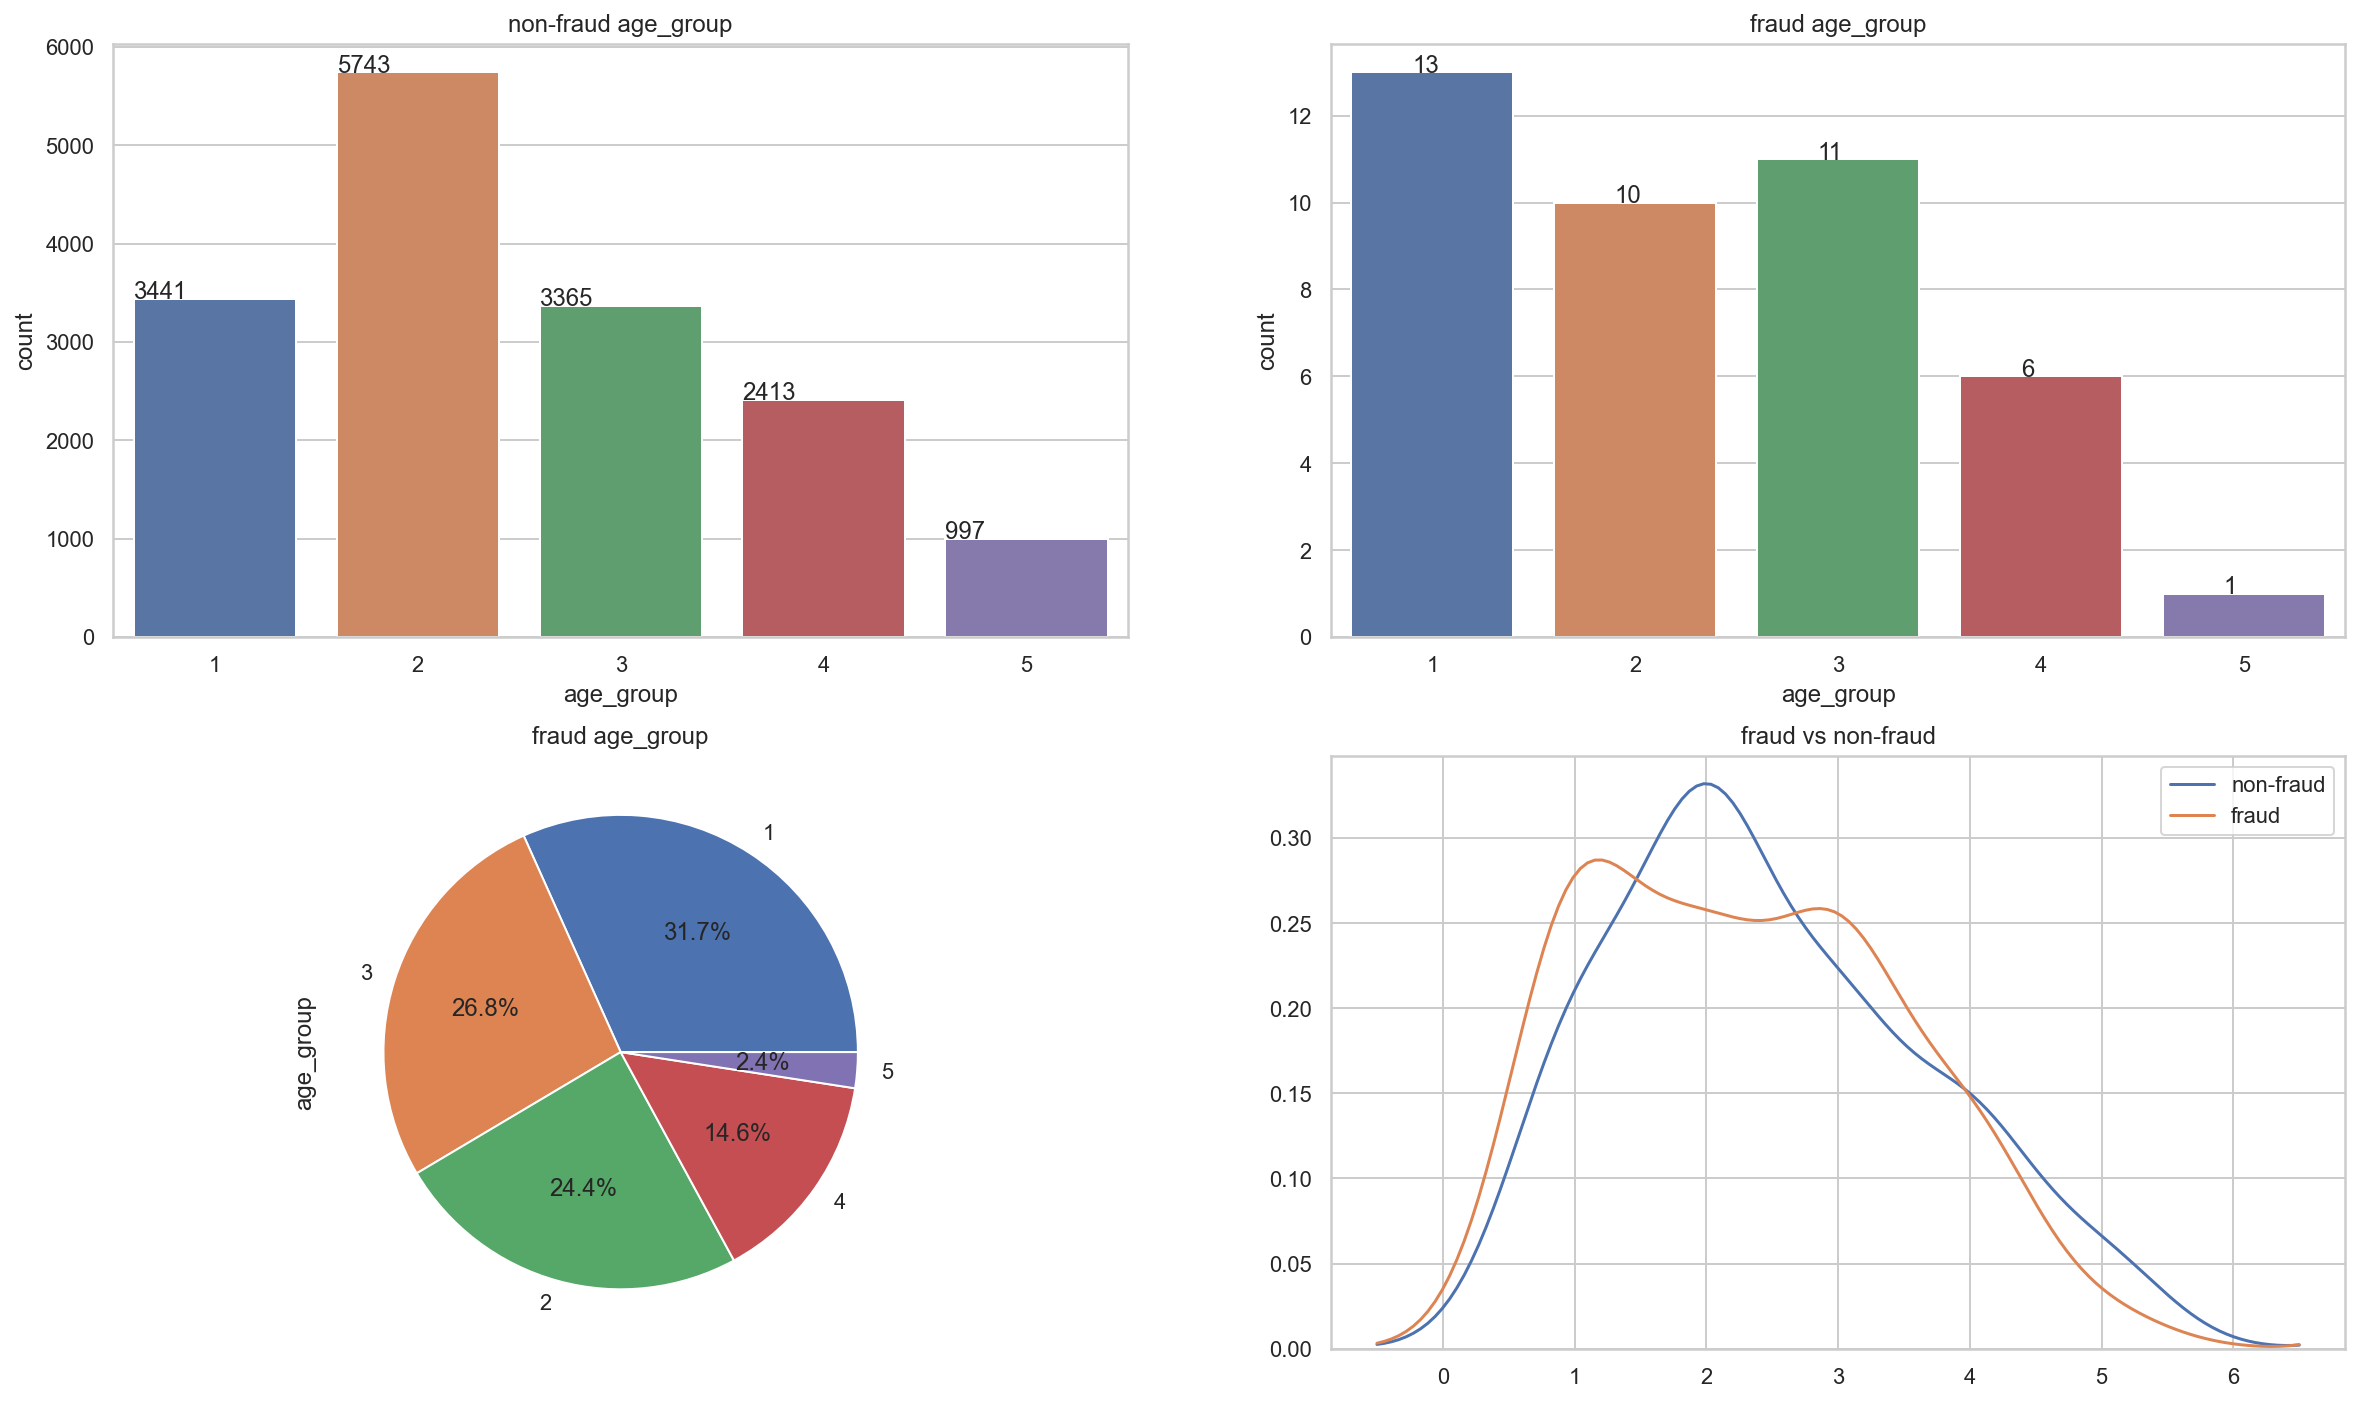

In [71]:
make_graph('age_group')

- 20대 초반과 20대 중후반(1,3)의 fraud 비율이 상대적으로 높음

## 10. insure_cost
보험손해비용
- 0 : 알 수 없음

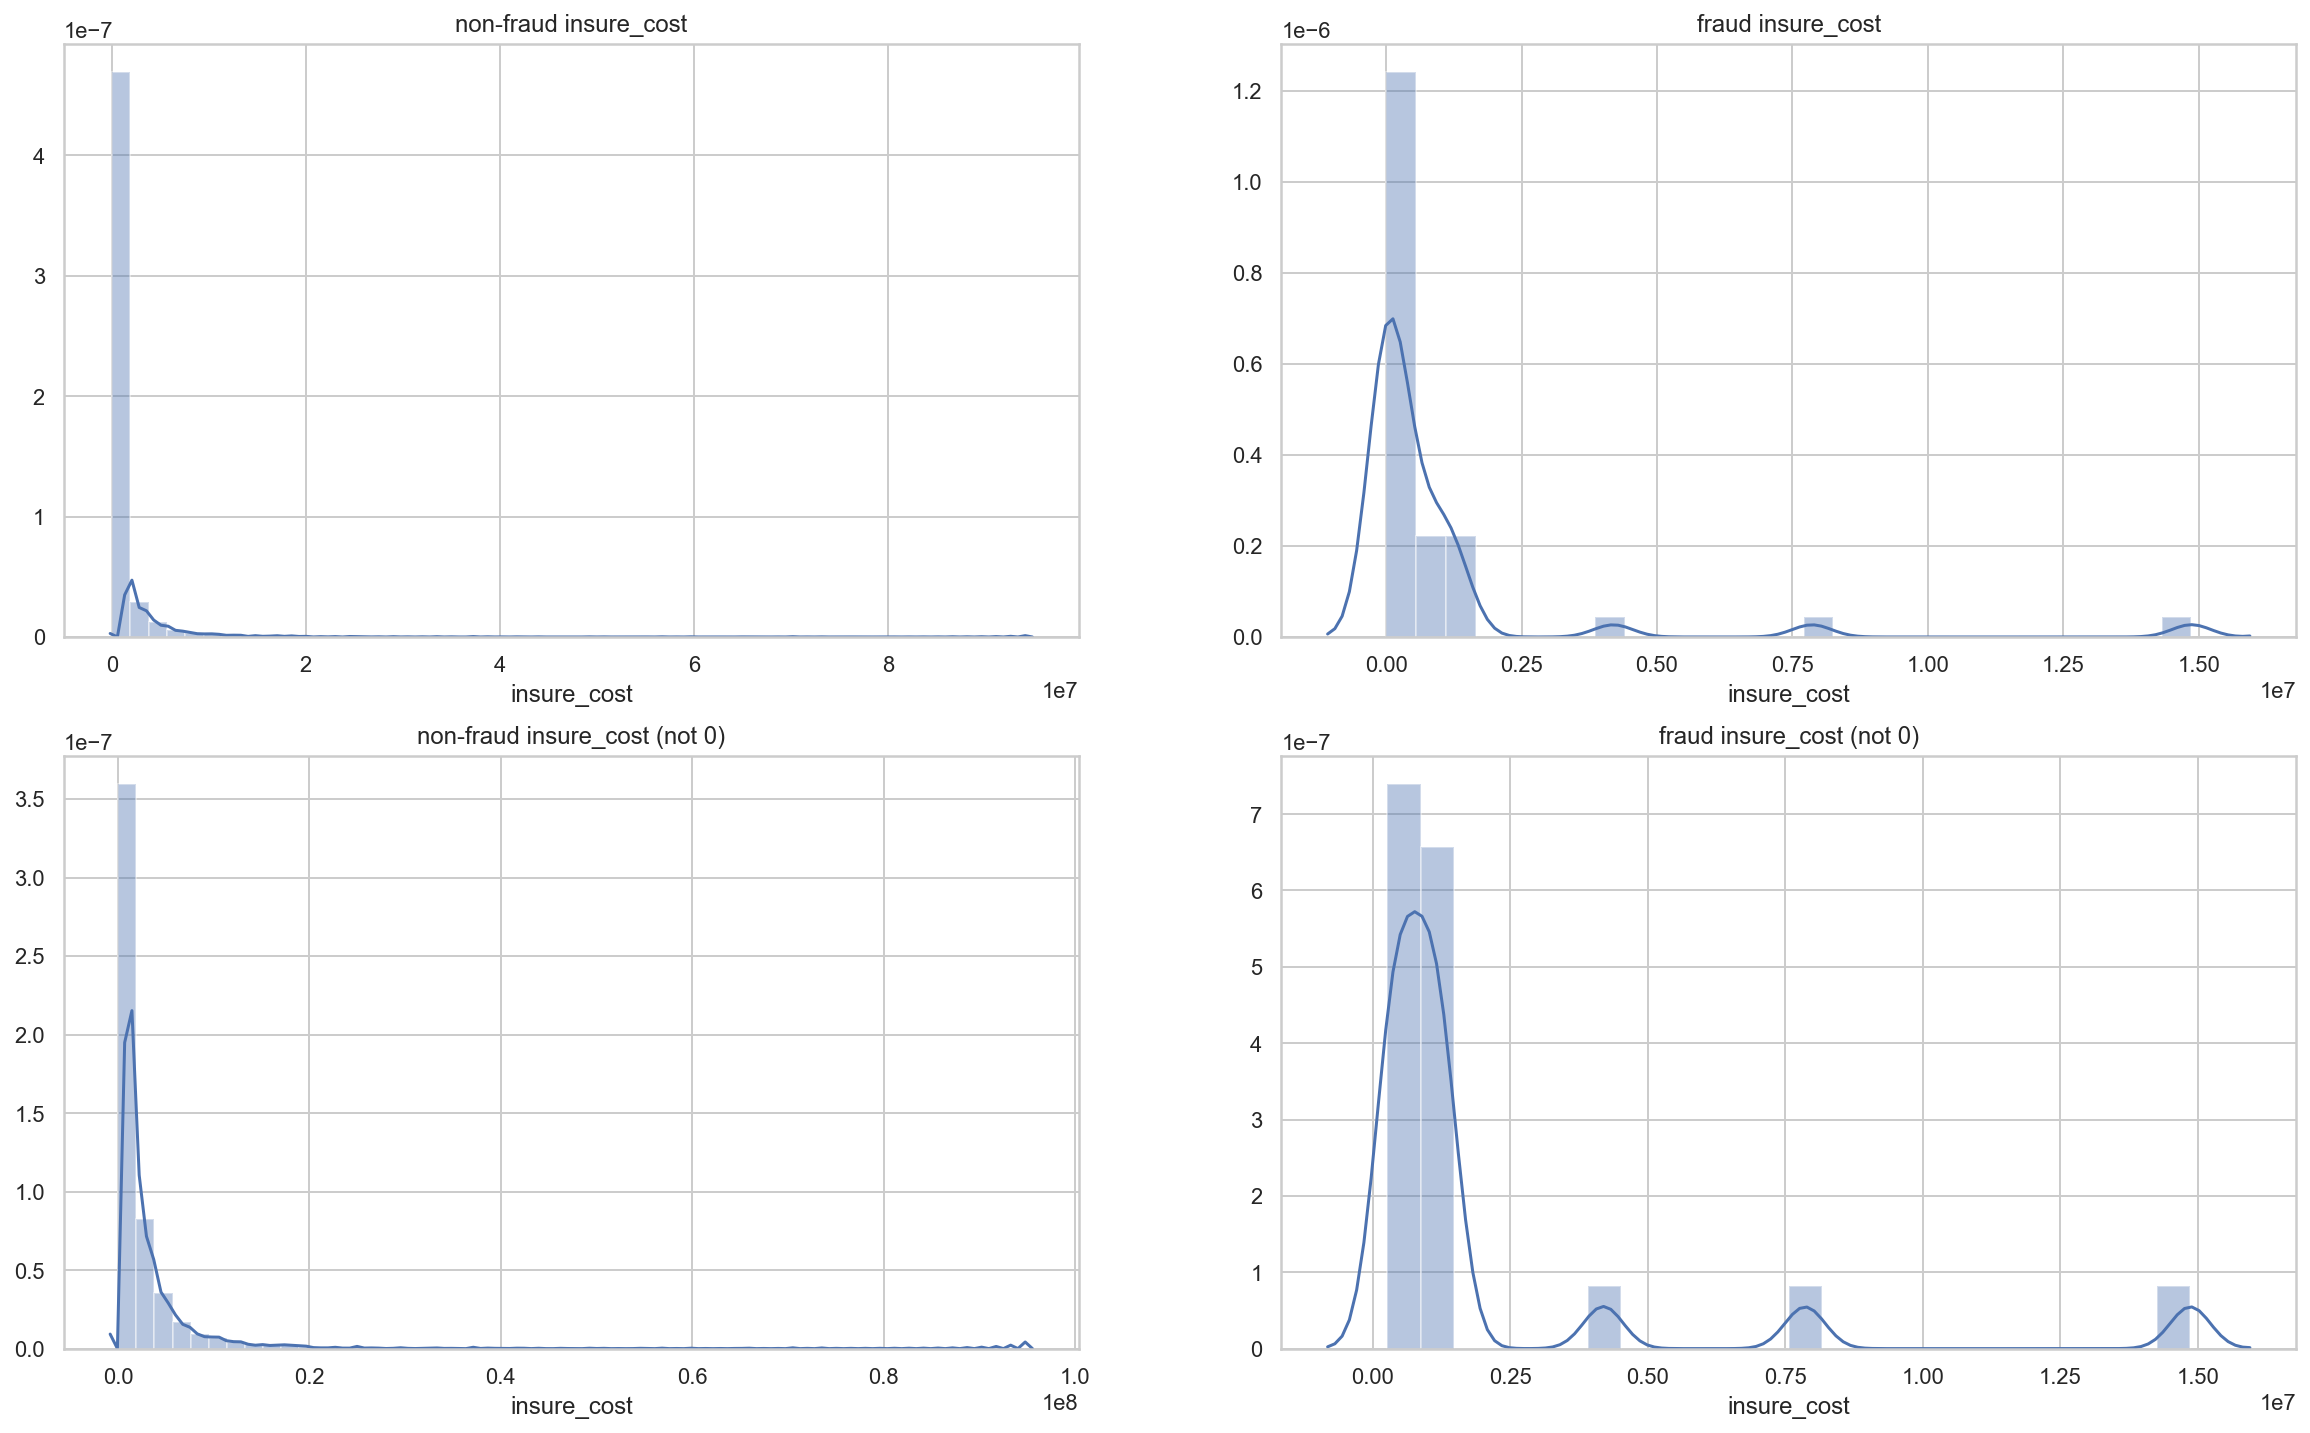

In [77]:
fig,ax = plt.subplots(2, 2, figsize=(20,12))

t0 = socar[socar['fraud_YN']==0]
t1 = socar[socar['fraud_YN']==1]

plt.subplot(2,2,1)
sns.distplot(socar[socar['fraud_YN']==0]['insure_cost'])
plt.title("non-fraud {}".format('insure_cost'))    

plt.subplot(2,2,2)
sns.distplot(socar[socar['fraud_YN']==1]['insure_cost'])
plt.title("fraud {}".format('insure_cost'))    

plt.subplot(2,2,3)
sns.distplot(socar[(socar['fraud_YN']==0) & (socar['insure_cost'] > 0)]['insure_cost'])
plt.title("non-fraud {} (no 0)".format('insure_cost'))  

plt.subplot(2,2,4)
sns.distplot(socar[(socar['fraud_YN']==1) & (socar['insure_cost'] > 0)]['insure_cost'])
plt.title("fraud {} (no 0)".format('insure_cost'))   

plt.show()

- 알수없음(0)이 fraud, non-fraud 모두에서 많이 나타남 -> null값에 특정값(평균, 중위값, k-means 등)을 넣어주거나 아예 컬럼 자체를 사용하지 않는 시도도 해볼 예정

## 11. repair_cost
차량수리비용
- 0 : 알 수 없음

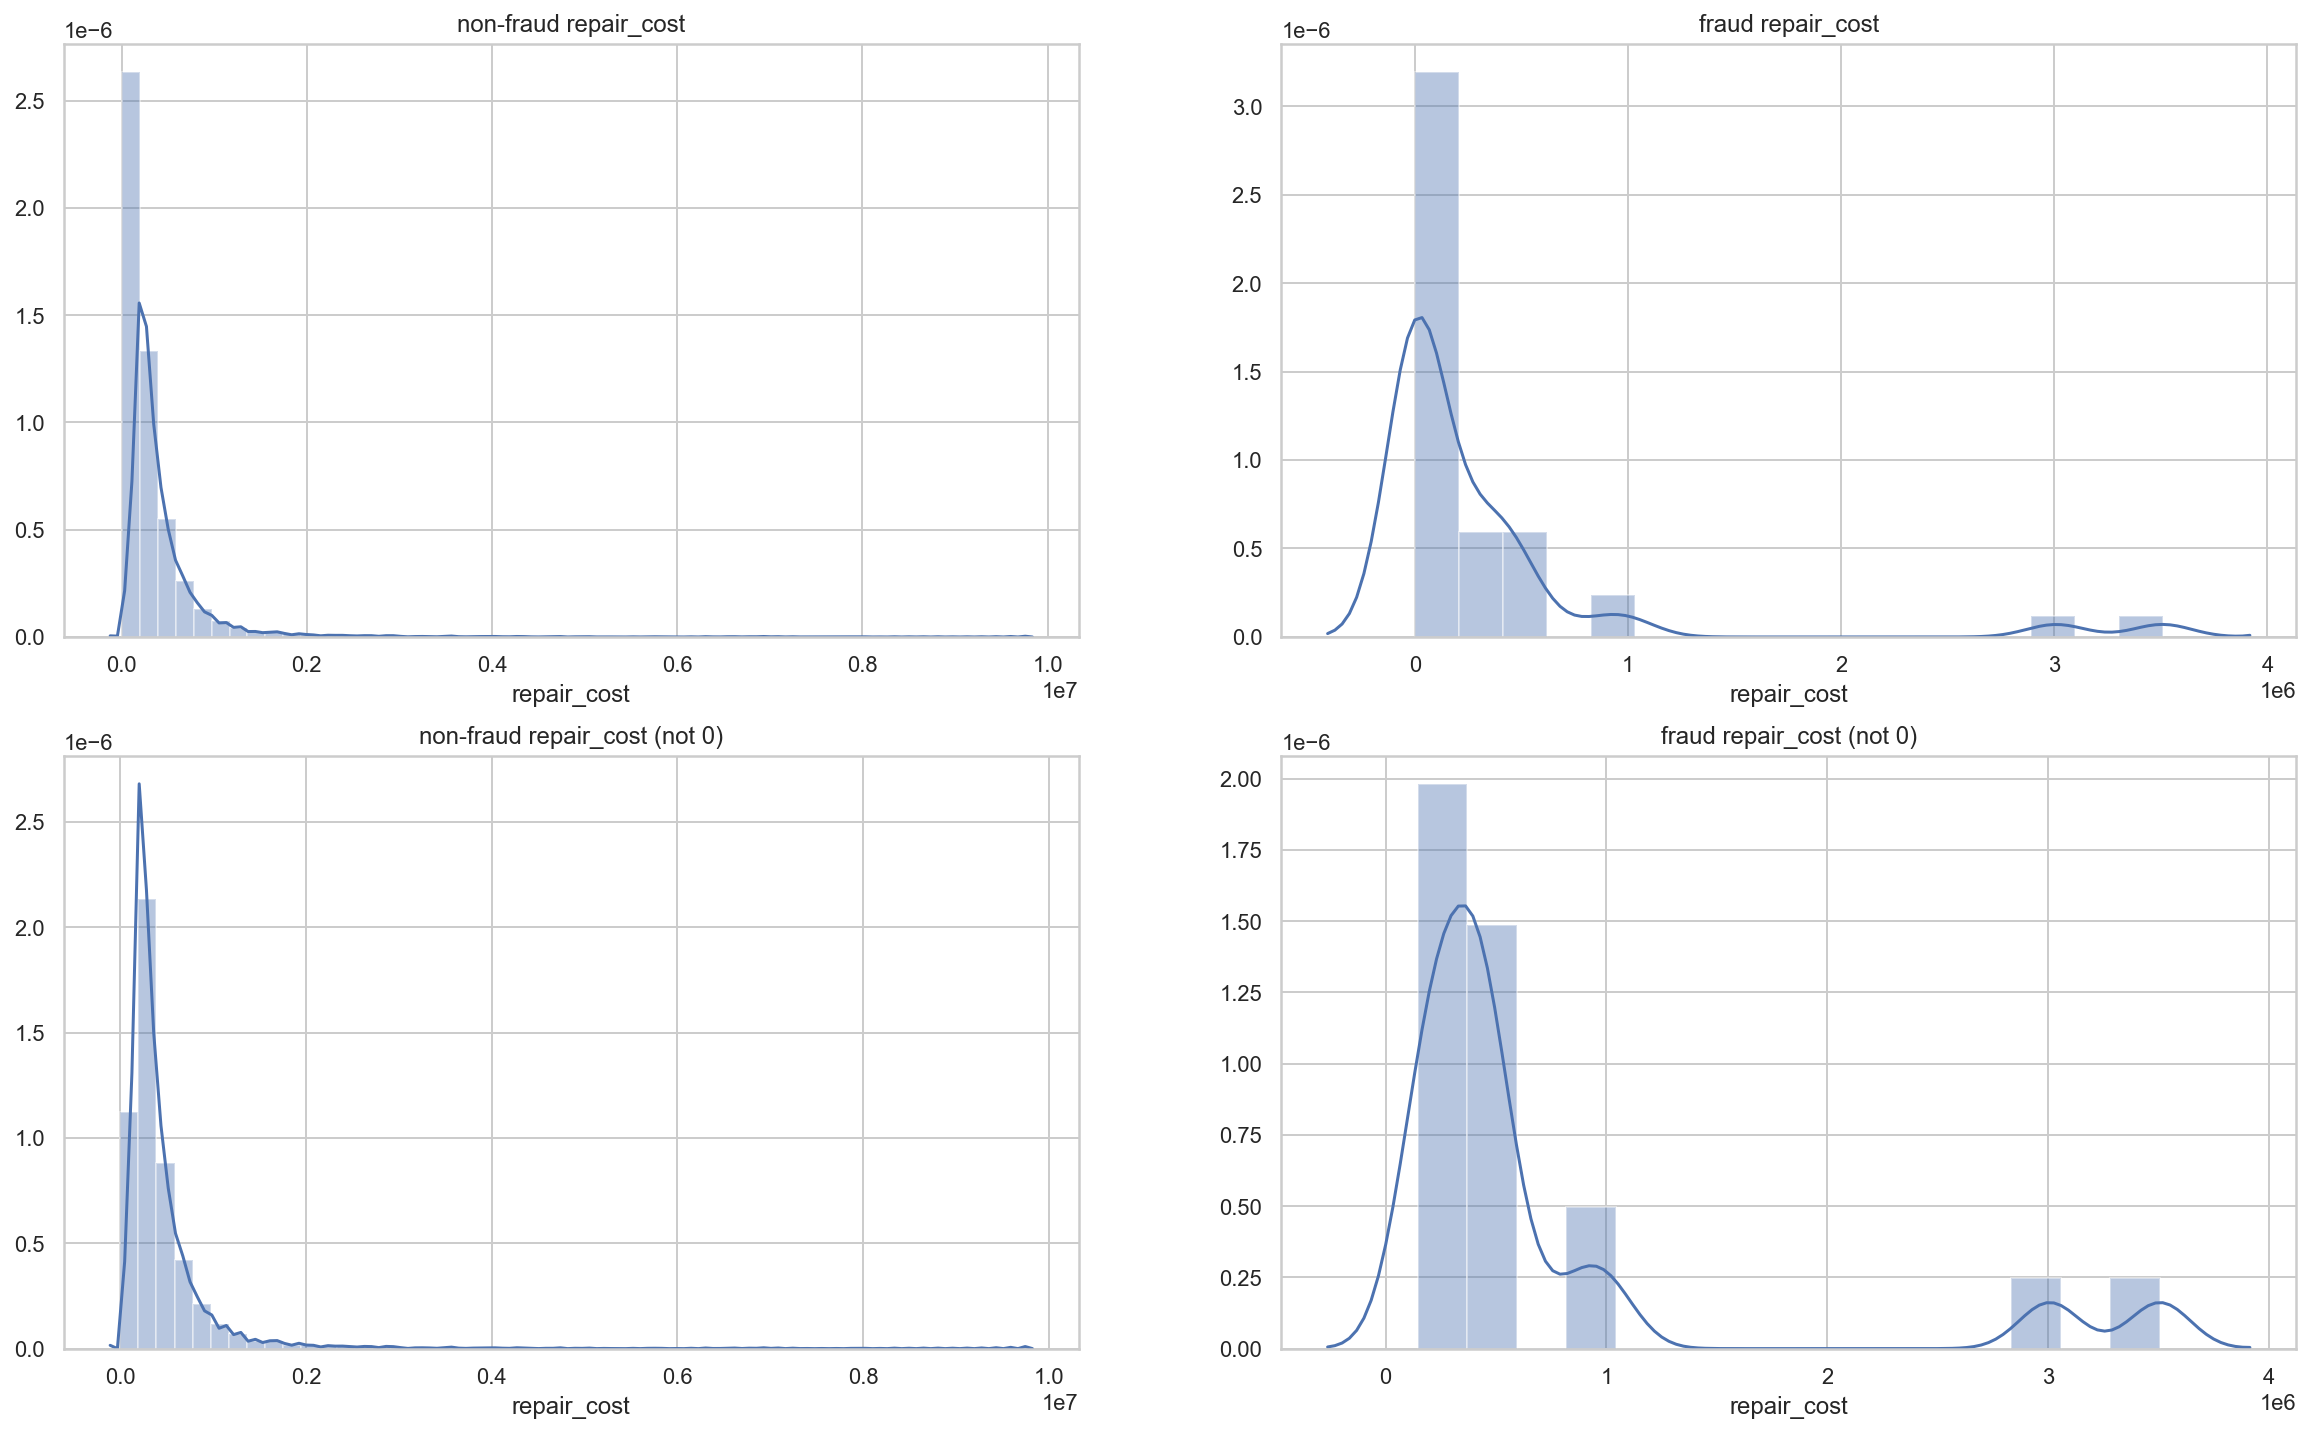

In [79]:
fig,ax = plt.subplots(2, 2, figsize=(20,12))

t0 = socar[socar['fraud_YN']==0]
t1 = socar[socar['fraud_YN']==1]

plt.subplot(2,2,1)
sns.distplot(socar[socar['fraud_YN']==0]['repair_cost'])
plt.title("non-fraud {}".format('repair_cost'))    

plt.subplot(2,2,2)
sns.distplot(socar[socar['fraud_YN']==1]['repair_cost'])
plt.title("fraud {}".format('repair_cost'))    

plt.subplot(2,2,3)
sns.distplot(socar[(socar['fraud_YN']==0) & (socar['repair_cost'] > 0)]['repair_cost'])
plt.title("non-fraud {} (no 0)".format('repair_cost'))  

plt.subplot(2,2,4)
sns.distplot(socar[(socar['fraud_YN']==1) & (socar['repair_cost'] > 0)]['repair_cost'])
plt.title("fraud {} (no 0)".format('repair_cost'))   

plt.show()

- insure_cost와 같이 알수없음(0)이 다수 존재함
- fraud 데이터에서 repair_cost가 300만원 이상 나온 케이스 몇 건 존재 -> 범행 과정에서 의도치 않게 사고가 크게 난 이상치가 아닐까 판단됨

# 데이터 전처리 & 모델링

## 원핫인코딩

In [3]:
cat_attribs = socar_df.columns.drop(['fraud_YN', 'accident_ratio', 'repair_cost', 'insure_cost', 'repair_cnt', 'test_set'])
                
socar_df = pd.get_dummies(socar_df, columns=cat_attribs)

## 데이터 분리

In [4]:
# train_set, test_set 분리
train_set = socar_df[socar_df["test_set"] == 0]
test_set = socar_df[socar_df["test_set"] == 1]

# "test_set" 컬럼 삭제
train_set = train_set.drop("test_set", axis=1)
test_set = test_set.drop("test_set", axis=1)

# features와 target분리
X = train_set.drop("fraud_YN", axis=1)
y = train_set["fraud_YN"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)
X_test, y_test = test_set.drop("fraud_YN", axis=1), test_set["fraud_YN"]

## 샘플링

In [5]:
over_sampling = RandomOverSampler(random_state=13)
X_train_over, y_train_over = over_sampling.fit_sample(X_train, y_train)

## 파이프라인

In [47]:
# pipeline
scaler = ("scaler", RobustScaler())
pca = ('pca', PCA(n_components=4))

lr_pipe = Pipeline([scaler, pca, ("clf", LogisticRegression(random_state=13))])
dt_pipe = Pipeline([scaler, pca, ("clf", DecisionTreeClassifier(random_state=13))])
rf_pipe = Pipeline([scaler, pca, ("clf", RandomForestClassifier(random_state=13))])
lgbm_pipe = Pipeline([scaler, pca, ("clf", LGBMClassifier(random_state=13))])
svm_pipe = Pipeline([scaler, pca, ("clf", LinearSVC(random_state=13))])


# grid search params
lr_param_grid = [{'clf__penalty': ['l2', 'elasticnet', 'none']}]
dt_param_grid = [{'clf__criterion':['gini', 'entropy'], 'clf__max_depth':[None,2,3,4,5,6]}]
rf_param_grid = [{'clf__n_estimators': [5, 10, 20], 'clf__max_depth' : [2, 3, 4, 5, 10, 50, 100]}]
lgbm_param_grid = [{'clf__n_estimators': [800, 1000, 1200], 'clf__num_leaves': [32, 64],
                   'clf__max_depth': [128, 160], 'clf__min_child_samples': [60, 100]}]
svm_param_grid = [{"clf__penalty": ["l1", "l2"], "clf__loss": ["hinge", "squared_hinge"]}]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

# grid search CV
LR = GridSearchCV(lr_pipe, lr_param_grid, cv=kfold, scoring = 'recall')
DT = GridSearchCV(dt_pipe, dt_param_grid, cv=kfold, scoring = 'recall')
RF = GridSearchCV(rf_pipe, rf_param_grid, cv=kfold, scoring = 'recall')
LGBM = GridSearchCV(lgbm_pipe, lgbm_param_grid, cv=kfold, scoring = 'recall')
SVM = GridSearchCV(svm_pipe, svm_param_grid, cv=kfold, scoring = 'recall')

## 성능 평가 함수

In [48]:
def get_score(X_train, y_train, X_valid, y_valid, X_test, y_test):    
    grids = [('LogisticRegression', LR), ('DecisionTree', DT), ('RandomForest', RF), ('LightGBM', LGBM), ('LinearSVC', SVM)]
                  
    df = []
    
    for name, grid in grids:
        clf = grid
        clf.fit(X_train, y_train)
        
        y_pred_valid = clf.predict(X_valid)
        y_pred_test = clf.predict(X_test)
        
        print('{} 교차검증 recall:{}, 최적의 파라미터:{}'.format(name, round(clf.best_score_,3), clf.best_params_))
    
        df.append({
            'model_name' : name,
            'valid_accuracy' : accuracy_score(y_valid, y_pred_valid),
            'valid_recall' : recall_score(y_valid, y_pred_valid),
            'valid_precision' : precision_score(y_valid, y_pred_valid),
            'valid_f1' : f1_score(y_valid, y_pred_valid),
            'valid_roc' : roc_auc_score(y_valid, y_pred_valid),
            'test_accuracy' : accuracy_score(y_test, y_pred_test),
            'test_recall' : recall_score(y_test, y_pred_test),
            'test_precision' : precision_score(y_test, y_pred_test),
            'test_f1' : f1_score(y_test, y_pred_test),
            'test_roc' : roc_auc_score(y_test, y_pred_test)
        })
    
    result = pd.DataFrame(df) 
    
    return result


In [49]:
get_score(X_train, y_train, X_valid, y_valid, X_test, y_test)

LogisticRegression 교차검증 recall:0.0, 최적의 파라미터:{'clf__penalty': 'l2'}
DecisionTree 교차검증 recall:0.0, 최적의 파라미터:{'clf__criterion': 'gini', 'clf__max_depth': None}
RandomForest 교차검증 recall:0.0, 최적의 파라미터:{'clf__max_depth': 2, 'clf__n_estimators': 5}
LightGBM 교차검증 recall:0.0, 최적의 파라미터:{'clf__max_depth': 128, 'clf__min_child_samples': 60, 'clf__n_estimators': 800, 'clf__num_leaves': 32}
LinearSVC 교차검증 recall:0.0, 최적의 파라미터:{'clf__loss': 'hinge', 'clf__penalty': 'l2'}


,model_name,valid_accuracy,valid_recall,valid_precision,valid_f1,valid_roc,test_accuracy,test_recall,test_precision,test_f1,test_roc
0,LogisticRegression,0.997283,0.0,0.0,0.0,0.500000,0.997757,0.000000,0.000000,0.000000,0.500000
1,DecisionTree,0.993012,0.0,0.0,0.0,0.497859,0.992951,0.142857,0.058824,0.083333,0.568860
2,RandomForest,0.997283,0.0,0.0,0.0,0.500000,0.997757,0.000000,0.000000,0.000000,0.500000
3,LightGBM,0.996894,0.0,0.0,0.0,0.499805,0.997437,0.000000,0.000000,0.000000,0.499839
4,LinearSVC,0.997283,0.0,0.0,0.0,0.500000,0.997757,0.000000,0.000000,0.000000,0.500000


In [50]:
get_score(X_train_over, y_train_over, X_valid, y_valid, X_test, y_test)

LogisticRegression 교차검증 recall:0.781, 최적의 파라미터:{'clf__penalty': 'none'}
DecisionTree 교차검증 recall:1.0, 최적의 파라미터:{'clf__criterion': 'gini', 'clf__max_depth': None}
RandomForest 교차검증 recall:1.0, 최적의 파라미터:{'clf__max_depth': 10, 'clf__n_estimators': 5}
LightGBM 교차검증 recall:1.0, 최적의 파라미터:{'clf__max_depth': 128, 'clf__min_child_samples': 60, 'clf__n_estimators': 800, 'clf__num_leaves': 32}
LinearSVC 교차검증 recall:0.523, 최적의 파라미터:{'clf__loss': 'hinge', 'clf__penalty': 'l2'}


,model_name,valid_accuracy,valid_recall,valid_precision,valid_f1,valid_roc,test_accuracy,test_recall,test_precision,test_f1,test_roc
0,LogisticRegression,0.693323,0.428571,0.003802,0.007538,0.561308,0.593400,0.571429,0.003150,0.006265,0.582439
1,DecisionTree,0.995730,0.000000,0.000000,0.000000,0.499221,0.994233,0.000000,0.000000,0.000000,0.498234
2,RandomForest,0.995342,0.000000,0.000000,0.000000,0.499027,0.993592,0.000000,0.000000,0.000000,0.497913
3,LightGBM,0.997283,0.000000,0.000000,0.000000,0.500000,0.996796,0.000000,0.000000,0.000000,0.499518
4,LinearSVC,0.808230,0.428571,0.006085,0.012000,0.618918,0.649471,0.285714,0.001833,0.003643,0.468002


In [ ]:
# example - 데이터 복사본 생성 후 전처리(컬럼 제거, 결측치 채우기 등 자유롭게)
socar_1 = socar_df.copy()
socar_1.drop('car_model', axis=1)

In [ ]:
# example - 원핫인코딩
cat_attribs = socar_1.columns.drop(['fraud_YN', 'accident_ratio', 'repair_cost', 'insure_cost', 'repair_cnt', 'test_set'])
                
socar_1 = pd.get_dummies(socar_1, columns=cat_attribs)

In [ ]:
# example - 데이터 분리
train_set = socar_1[socar_df["test_set"] == 0]
test_set = socar_1[socar_df["test_set"] == 1]

# "test_set" 컬럼 삭제
train_set = train_set.drop("test_set", axis=1)
test_set = test_set.drop("test_set", axis=1)

# features와 target분리
X = train_set.drop("fraud_YN", axis=1)
y = train_set["fraud_YN"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)
X_test, y_test = test_set.drop("fraud_YN", axis=1), test_set["fraud_YN"]

In [ ]:
# example - 샘플링
over_sampling = RandomOverSampler(random_state=13)
X_train_over, y_train_over = over_sampling.fit_sample(X_train, y_train)

In [ ]:
# example - 성능 평가
get_score(X_train_over, y_train_over, X_valid, y_valid, X_test, y_test)